In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
import torch
import torch_geometric
import torch
import os
import os.path as osp
import numpy as np
from tqdm import tqdm as tqdm
torch.manual_seed(1)
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# import electron datasets
import glob
#raw_dir="/grid_mnt/data__data.polcms/cms/sghosh/hackathon/graphsv1/"
raw_dir="/grid_mnt/data__data.polcms/cms/sghosh/hackathon/graphsv2_thr0p2phi0p2/"
#raw_dir='/data_CMS/cms/sghosh/elecgraphs/V1condor/'
fnamelist = [filepath for filepath in glob.glob(raw_dir+'data*.pt')]
data_list_ele = []
etav = []
for i in tqdm(fnamelist):
    idx = torch.load(i)
    #print(idx.x.shape[0])
    if idx.x.shape[0] < 3:
        continue
    #if (idx.nodelabel==0).all:
    if not(np.any(idx.nodelabel.numpy())):  ### remove where there are no eles matched
        continue
    #idx.edge_index = idx.edgeidx.long()
    idx.edgeidx = []
    data_list_ele.append(idx)
    #data_list.append(torch.load(i))
    

#data_list=[x for x in data_list if (x.y<100.)]   
print((data_list_ele[0].x))

print(len(data_list_ele))

#trainev =

100%|██████████| 58917/58917 [00:35<00:00, 1673.26it/s]

tensor([[ 6.1590e+01, -5.8120e+00,  3.2511e+02,  2.0705e+00,  3.5077e-01,
          1.8955e-03,  9.3646e-01,  1.7226e-01],
        [ 5.4722e+01, -9.9162e+00,  3.2988e+02,  7.7504e+00,  8.3204e-02,
         -7.8913e-02,  9.9340e-01,  9.4590e-02],
        [ 5.4792e+01, -1.5136e+01,  3.3019e+02,  1.5054e+01,  1.3933e-01,
         -5.3625e-02,  9.8879e-01,  2.5845e-02],
        [ 5.7434e+01, -1.7210e+01,  3.2712e+02,  3.0184e+00, -4.5120e-02,
         -2.9879e-01,  9.5325e-01,  3.3228e-01],
        [ 5.8495e+01, -1.4197e+01,  3.2995e+02,  7.7778e-01,  1.5388e-01,
         -4.1134e-02,  9.8723e-01,  2.0848e-02],
        [ 6.0202e+01, -1.1856e+01,  3.3360e+02,  5.2617e+00,  1.8776e-01,
         -1.2751e-01,  9.7390e-01,  9.3655e-02],
        [ 6.1393e+01, -7.7536e+00,  3.3109e+02,  3.0767e+00,  2.7094e-01,
          6.8845e-02,  9.6013e-01,  1.2980e-01],
        [ 5.3352e+01, -1.9245e+01,  3.3362e+02,  2.4999e+00,  1.4660e-01,
         -9.3981e-02,  9.8472e-01,  3.8743e-02],
        [ 5.8178

In [4]:
print(data_list_ele[0].keys)
print(data_list_ele[0].nodelabel)
print(data_list_ele[0].x.shape)
print(data_list_ele[0].edge_index)
print(data_list_ele[0].edgelabel.shape)

['x', 'edgeidx', 'edgelabel', 'nodelabel']
tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
torch.Size([10, 8])
None
torch.Size([90])


In [11]:
#del data_list_comb
totalevele = len(data_list_ele)
ntrain = int(0.8*totalevele)
import random


random.shuffle(data_list_ele)
import torch_geometric
ntrainbatch = 100
ntestbatch = 100
trainloader = torch_geometric.data.DataLoader(data_list_ele[:ntrain], batch_size=ntrainbatch)
testloader = torch_geometric.data.DataLoader(data_list_ele[ntrain:], batch_size=ntestbatch)
#batch_size = ntrainbatch
epoch_size = len(data_list_ele[:ntrain])
print("epoch size,batch_size:",epoch_size,ntrainbatch)

epoch size,batch_size: 16736 100


In [17]:
import os
import os.path as osp
import math

import numpy as np
import torch
import gc
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch.utils.checkpoint import checkpoint
from torch_cluster import knn_graph

from torch_geometric.nn import EdgeConv, NNConv
from torch_geometric.nn import GATConv
#from torch_geometric.nn.pool.edge_pool import EdgePooling

from torch_geometric.utils import normalized_cut
from torch_geometric.utils import remove_self_loops
from torch_geometric.utils.undirected import to_undirected
from torch_geometric.nn import (graclus, max_pool, max_pool_x,
                                global_mean_pool, global_max_pool,
                                global_add_pool,BatchNorm)

transform = T.Cartesian(cat=False)

def normalized_cut_2d(edge_index, pos):
    row, col = edge_index
    edge_attr = torch.norm(pos[row] - pos[col], p=2, dim=1)
    return normalized_cut(edge_index, edge_attr, num_nodes=pos.size(0))

class NodeNetwork(nn.Module):
    # Nodeclassification network 
    
    def __init__(self, input_dim=5, hidden_dim=64, output_dim=1, k=16, aggr='add',
                 norm=torch.tensor([1./500., 1./500., 1./54., 1/25., 1./1000.])):
 #                norm=torch.tensor([1., 1., 1., 1., 1.])):
        super(NodeNetwork, self).__init__()

        self.datanorm = nn.Parameter(norm,requires_grad=False)
        
        self.k = k
        start_width = 2 * hidden_dim
        middle_width = 3 * hidden_dim // 2

        
        
        self.inputnet =  nn.Sequential(
            nn.Linear(input_dim, hidden_dim*2),            
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim*2, hidden_dim*2),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim*2, hidden_dim*2),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim*2, hidden_dim*2),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ELU(),
        )
        
        
        convnn1 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.ELU(),
                                nn.Dropout(0.2),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.ELU()
                                )
        convnn2 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.ELU(),
                                nn.Dropout(0.2),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.ELU()
                                )
        
        convnn3 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.ELU(),
                                nn.Dropout(0.2),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.ELU(),
                                nn.Linear(hidden_dim, output_dim)                                           
                                )
                
        self.edgeconv1 = EdgeConv(nn=convnn1, aggr=aggr)
        self.edgeconv2 = EdgeConv(nn=convnn2, aggr=aggr)
        self.edgeconv3 = EdgeConv(nn=convnn3, aggr=aggr)
        
        self.output = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                    nn.ELU(),
                                    nn.Dropout(0.2),
                                    #nn.Softplus(),
                                    nn.Linear(hidden_dim, hidden_dim//2),
                                    nn.ELU(),
                                    nn.Dropout(0.2),
                                    #nn.Softplus(),
#                                    nn.Linear(hidden_dim//2, hidden_dim//2),#added
 #                                   nn.ELU(),
                                    #nn.Softplus(),
                                    nn.Linear(hidden_dim//2, output_dim)
                                   )
        self.batchnorm1 = BatchNorm(hidden_dim)
        self.gat1 = GATConv(hidden_dim, hidden_dim,add_self_loops=False,heads=3,concat=False)#, heads=self.in_head, dropout=0.6)
        self.gat2 = GATConv(hidden_dim, hidden_dim,add_self_loops=False,heads=3,concat=False)
        self.gat3 = GATConv(hidden_dim, hidden_dim,add_self_loops=False,heads=3,concat=False)
    def forward(self, data):        
        data.x = self.datanorm * data.x
        data.x = self.inputnet(data.x)
        orig_x = data.x.clone()
        
        data.edge_index = to_undirected(knn_graph(data.x, self.k, data.batch, loop=False, flow=self.edgeconv1.flow))
        data.x = self.edgeconv1(data.x, data.edge_index)
        data.x = self.gat1(data.x,data.edge_index,return_attention_weights=False)[0]
        data.x = torch.add(data.x,orig_x)
        
        data.edge_index = to_undirected(knn_graph(data.x, self.k, data.batch, loop=False, flow=self.edgeconv1.flow))
        data.x = self.edgeconv2(data.x, data.edge_index)
        data.x = self.gat2(data.x,data.edge_index,return_attention_weights=False)[0]
        data.x = torch.add(data.x,orig_x)
        data.x = self.edgeconv3(data.x, data.edge_index)
        output = data.x
        
        
        return output.squeeze(-1)

In [22]:
from lr_regulation import *

from tqdm import tqdm_notebook as tqdm


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.drn = NodeNetwork(input_dim=8,
                                           hidden_dim=100, #50
                                           k=16,#16
                                           output_dim=2,
                                           norm=torch.tensor([1., 1., 1., 1.,1.,1.,1.,1.]))
        
    def forward(self, data):
        logits = self.drn(data)
        #return F.softplus(logits)
        return logits
device = torch.device('cuda:1')#('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
model = Net().to(device)
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
#optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-3)
scheduler = CyclicLRWithRestarts(optimizer, ntrainbatch, epoch_size, restart_period=200, t_mult=1.2, policy="cosine")

from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum() 

focalloss = FocalLoss()        


     
losscat = torch.nn.CrossEntropyLoss(weight=torch.tensor([10., 2.],device="cuda:1"))    
def categorical_loss(outputa,trutha,alpha):
    total_loss =  losscat(outputa[:,:2],trutha[:,0].long()) + alpha*resoloss(outputa[:,2],trutha[:,1])
    return total_loss


def categorical_loss_only(outputa,trutha):
    total_loss =  losscat(outputa,trutha.flatten().long()) 
    return total_loss


#model.train()
def train(epoch):
    model.train()
    torch.cuda.empty_cache()
    scheduler.step()
    loss = []
    for data in tqdm(trainloader):
            data = data.to(device)        
            optimizer.zero_grad()
            #print(data.x.size())
            result = model(data)
            lossc = categorical_loss_only(result, data.nodelabel.type(torch.int64))
            #lossc = focalloss(result, data.nodelabel.type(torch.int64))
            loss.append(lossc.item()) 
            lossc.backward()
            optimizer.step()
            scheduler.batch_step()
    print( 'batches for train:',len(loss)) 
#    print('loss',loss)
    print('train loss:',np.mean(np.array(loss)))
    return np.mean(np.array(loss))




def gaussian(x,  mean,a, sigma):
    return a * np.exp(-((x - mean)**2 / (2 * sigma**2)))

def evaluate(epoch):
        """"Evaluate the model"""
        model.zero_grad()
        torch.cuda.empty_cache()
        model.eval()
        pred = []
        true = []
        loss= []
        
        correct = 0
        predc = []
        truec = []
        for data in tqdm(testloader):
            data = data.to(device)        
            result = model(data)
            #lossc = resoloss(result, data.y)
            lossc = categorical_loss_only(result, data.nodelabel.type(torch.int64))
            #lossc = focalloss(result, data.nodelabel.type(torch.int64))
#            print (result.item(),data.y.item())
#            frac.append((result.item() - data.y.item())/data.y.item())
            loss.append(lossc.item())

            for i in result:
                #pred.append(i.detach().cpu()[2])
                predc.append(i.detach().cpu().argmax())
                #print(i.detach().cpu().argmax())
            for i in data.nodelabel.detach():
                #true.append(i.detach().cpu()[1])
                truec.append(i.detach().cpu().flatten())
                #print(i.detach().cpu())
            
        #print(predc,truec)
        predc = np.array(predc)
        truec = np.array(truec)
        
        #eleacc = [] 
        #puacc = []
        
        totacc = np.equal(predc,truec).sum()/len(truec)
        eleacc = np.equal(predc[truec==1],truec[truec==1]).sum()/len(truec[truec==1])
        puacc = np.equal(predc[truec==0],truec[truec==0]).sum()/len(truec[truec==0])


        return np.mean(np.array(loss)), totacc, eleacc, puacc
        


  2%|▏         | 3/168 [00:00<00:06, 25.23it/s]

epoch: 1


  7%|▋         | 3/42 [00:00<00:01, 22.64it/s]

batches for train: 168
train loss: 0.23018946401065304


  2%|▏         | 4/168 [00:00<00:04, 36.03it/s]

test total acc, ele acc, pu acc: 0.8217382925419155 0.0 1.0
new best test loss: 0.24028247949622927
epoch: 2


  5%|▍         | 2/42 [00:00<00:02, 18.58it/s]

batches for train: 168
train loss: 0.18795959997389997


  2%|▏         | 4/168 [00:00<00:04, 35.42it/s]

test total acc, ele acc, pu acc: 0.8194532389945764 0.0015444015444015444 0.996884213347628
new best test loss: 0.18759076900425412
epoch: 3


  5%|▍         | 2/42 [00:00<00:02, 18.00it/s]

batches for train: 168
train loss: 0.18984755323756308


  3%|▎         | 5/168 [00:00<00:03, 41.52it/s]

test total acc, ele acc, pu acc: 0.817388431572282 0.0013899613899613899 0.9944049852586438
epoch: 4


  7%|▋         | 3/42 [00:00<00:01, 23.04it/s]

batches for train: 168
train loss: 0.1859736946367082


  3%|▎         | 5/168 [00:00<00:03, 45.02it/s]

test total acc, ele acc, pu acc: 0.8179390468848938 0.0007722007722007722 0.9952090592334495
epoch: 5


  7%|▋         | 3/42 [00:00<00:01, 22.50it/s]

batches for train: 168
train loss: 0.18509697381939208


  2%|▏         | 4/168 [00:00<00:04, 33.91it/s]

test total acc, ele acc, pu acc: 0.8162321394157972 0.0013899613899613899 0.9929978558027338
epoch: 6


  7%|▋         | 3/42 [00:00<00:01, 22.96it/s]

batches for train: 168
train loss: 0.184078534178081


  2%|▏         | 4/168 [00:00<00:04, 39.25it/s]

test total acc, ele acc, pu acc: 0.8177188007598492 0.0013899613899613899 0.9948070222460467
epoch: 7


  7%|▋         | 3/42 [00:00<00:01, 23.85it/s]

batches for train: 168
train loss: 0.18209625150830971


  2%|▏         | 4/168 [00:00<00:04, 37.10it/s]

test total acc, ele acc, pu acc: 0.8165625086033642 0.021003861003861004 0.9891450013401233
epoch: 8


  5%|▍         | 2/42 [00:00<00:02, 18.00it/s]

batches for train: 168
train loss: 0.17986673285208998


  2%|▏         | 3/168 [00:00<00:06, 25.10it/s]

test total acc, ele acc, pu acc: 0.8206095311510613 0.001081081081081081 0.9983918520503886
new best test loss: 0.18733555539732888
epoch: 9


  7%|▋         | 3/42 [00:00<00:01, 23.89it/s]

batches for train: 168
train loss: 0.17894850068149112


  3%|▎         | 5/168 [00:00<00:03, 48.18it/s]

test total acc, ele acc, pu acc: 0.8217933540731768 0.0003088803088803089 1.0
new best test loss: 0.17241048245202928
epoch: 10


  7%|▋         | 3/42 [00:00<00:01, 23.59it/s]

batches for train: 168
train loss: 0.17429145558604173


100%|██████████| 42/42 [00:02<00:00, 19.11it/s]


test total acc, ele acc, pu acc: 0.8219860694325909 0.0015444015444015444 0.9999664969177164
new best test loss: 0.16751068830490112


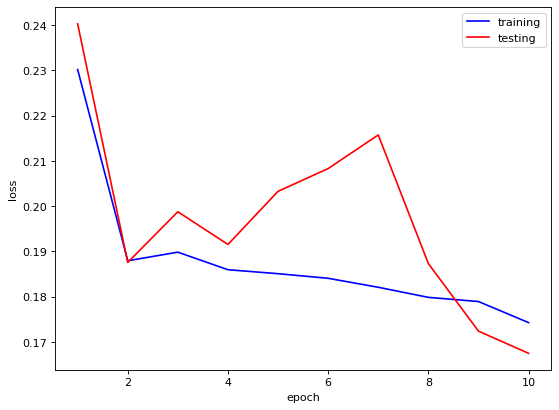

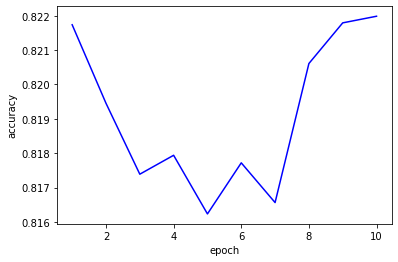

No handles with labels found to put in legend.


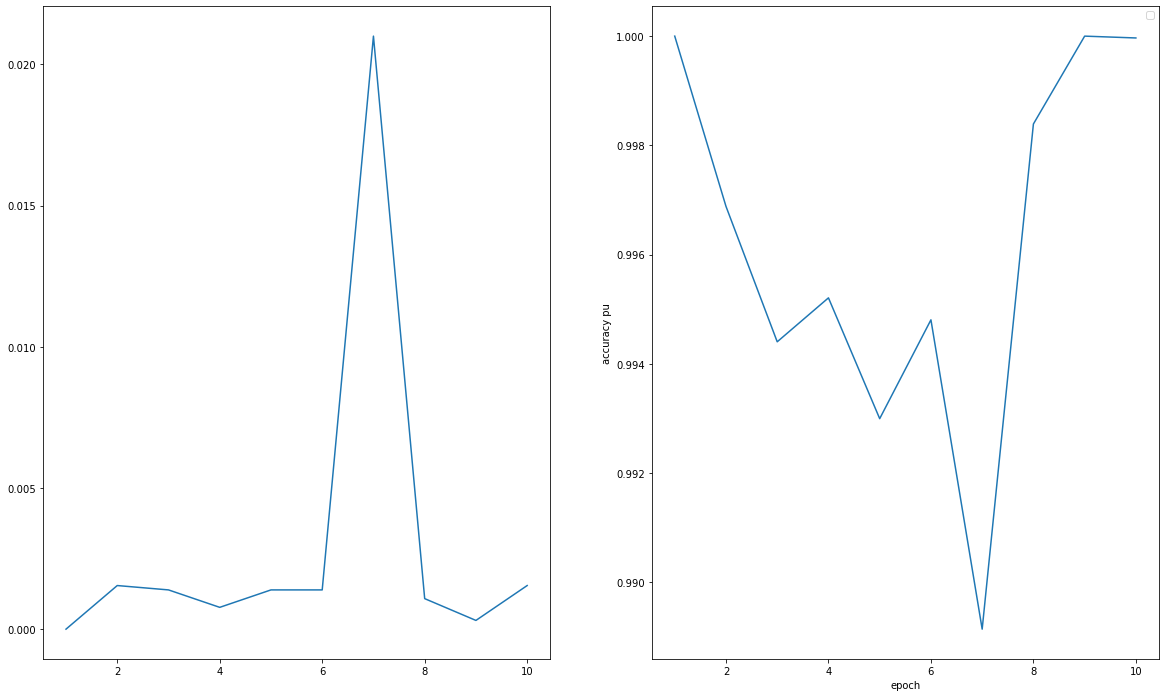

  3%|▎         | 5/168 [00:00<00:03, 42.66it/s]

epoch: 11


  7%|▋         | 3/42 [00:00<00:01, 23.49it/s]

batches for train: 168
train loss: 0.172455751913644


  4%|▎         | 6/168 [00:00<00:02, 55.57it/s]

test total acc, ele acc, pu acc: 0.8218208848388073 0.0004633204633204633 1.0
new best test loss: 0.16539219057276136
epoch: 12


  7%|▋         | 3/42 [00:00<00:01, 23.20it/s]

batches for train: 168
train loss: 0.1701068188995123


  3%|▎         | 5/168 [00:00<00:03, 43.31it/s]

test total acc, ele acc, pu acc: 0.8217382925419155 0.0003088803088803089 0.9999329938354329
epoch: 13


  5%|▍         | 2/42 [00:00<00:03, 12.18it/s]

batches for train: 168
train loss: 0.16155248365941502


  2%|▏         | 4/168 [00:00<00:04, 35.29it/s]

test total acc, ele acc, pu acc: 0.8223990309170498 0.004324324324324324 0.9998659876708658
new best test loss: 0.15424549615099317
epoch: 14


  5%|▍         | 2/42 [00:00<00:02, 17.59it/s]

batches for train: 168
train loss: 0.15513430518053828


  3%|▎         | 5/168 [00:00<00:03, 41.02it/s]

test total acc, ele acc, pu acc: 0.8221512540263745 0.0023166023166023165 1.0
new best test loss: 0.15339918647493636
epoch: 15


  7%|▋         | 3/42 [00:00<00:01, 22.91it/s]

batches for train: 168
train loss: 0.15687209057311216


  3%|▎         | 5/168 [00:00<00:03, 43.27it/s]

test total acc, ele acc, pu acc: 0.8224265616826804 0.00416988416988417 0.9999329938354329
epoch: 16


  7%|▋         | 3/42 [00:00<00:01, 23.04it/s]

batches for train: 168
train loss: 0.17020716908432187


  3%|▎         | 5/168 [00:00<00:03, 42.96it/s]

test total acc, ele acc, pu acc: 0.8217382925419155 0.0 1.0
epoch: 17


  7%|▋         | 3/42 [00:00<00:01, 23.28it/s]

batches for train: 168
train loss: 0.17004647034974324


  3%|▎         | 5/168 [00:00<00:03, 41.55it/s]

test total acc, ele acc, pu acc: 0.8217382925419155 0.0 1.0
epoch: 18


  5%|▍         | 2/42 [00:00<00:02, 18.05it/s]

batches for train: 168
train loss: 0.1684979149805648


  3%|▎         | 5/168 [00:00<00:03, 42.94it/s]

test total acc, ele acc, pu acc: 0.8217382925419155 0.0 1.0
epoch: 19


  7%|▋         | 3/42 [00:00<00:01, 23.25it/s]

batches for train: 168
train loss: 0.16738517750941573


  2%|▏         | 3/168 [00:00<00:06, 25.64it/s]

test total acc, ele acc, pu acc: 0.8217382925419155 0.0 1.0
epoch: 20


  7%|▋         | 3/42 [00:00<00:01, 23.31it/s]

batches for train: 168
train loss: 0.16710930477295602


100%|██████████| 42/42 [00:01<00:00, 23.64it/s]


test total acc, ele acc, pu acc: 0.8217382925419155 0.0 1.0


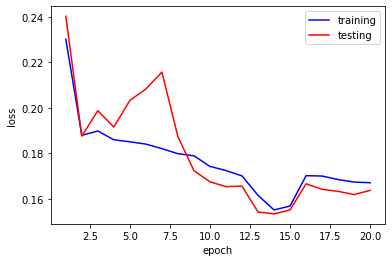

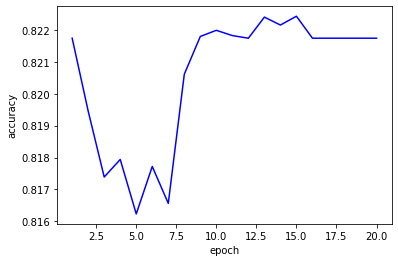

No handles with labels found to put in legend.


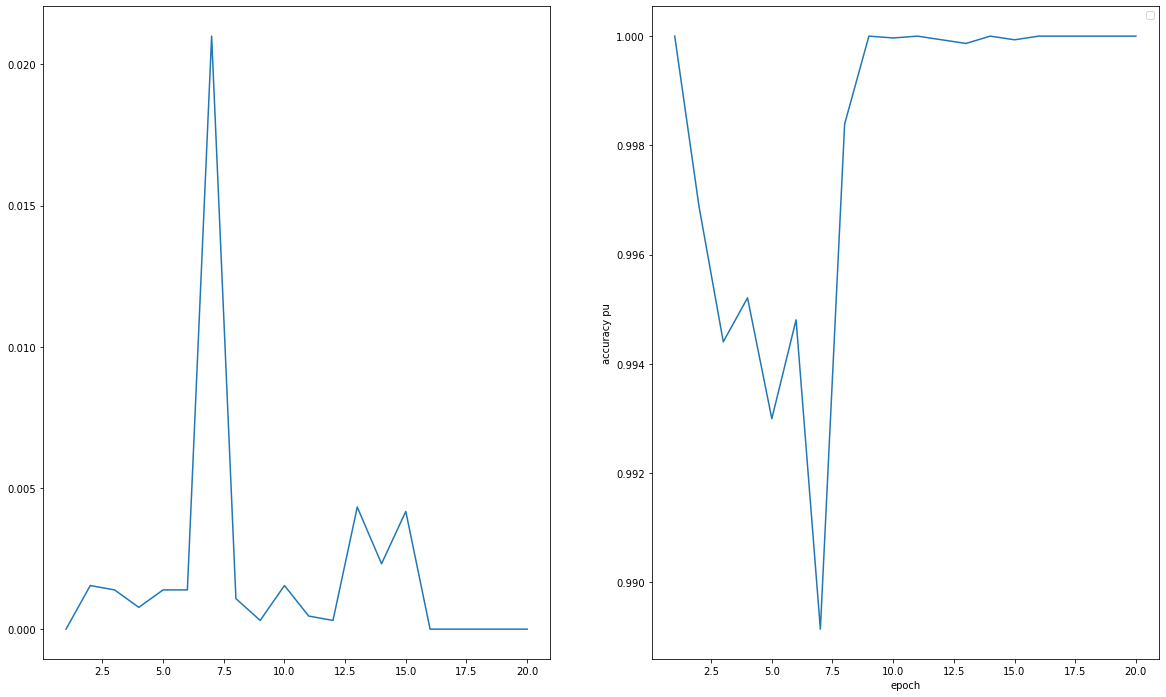

  3%|▎         | 5/168 [00:00<00:03, 41.23it/s]

epoch: 21


  7%|▋         | 3/42 [00:00<00:01, 23.70it/s]

batches for train: 168
train loss: 0.16699075299714292


  3%|▎         | 5/168 [00:00<00:03, 42.51it/s]

test total acc, ele acc, pu acc: 0.8216557002450238 0.0 0.9998994907531493
epoch: 22


  7%|▋         | 3/42 [00:00<00:01, 23.00it/s]

batches for train: 168
train loss: 0.16574677106525218


  2%|▏         | 3/168 [00:00<00:07, 23.35it/s]

test total acc, ele acc, pu acc: 0.8217382925419155 0.0 1.0
epoch: 23


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 0.15768034073213735


  0%|          | 0/168 [00:00<?, ?it/s]

test total acc, ele acc, pu acc: 0.8217382925419155 0.0 1.0
new best test loss: 0.15278644469522296
epoch: 24


  5%|▍         | 2/42 [00:00<00:02, 17.97it/s]

batches for train: 168
train loss: 0.15518542246094771


  3%|▎         | 5/168 [00:00<00:03, 42.61it/s]

test total acc, ele acc, pu acc: 0.8221512540263745 0.0027799227799227798 0.9998994907531493
epoch: 25


  7%|▋         | 3/42 [00:00<00:01, 22.84it/s]

batches for train: 168
train loss: 0.15474354120947065


  2%|▏         | 4/168 [00:00<00:05, 32.43it/s]

test total acc, ele acc, pu acc: 0.8217382925419155 0.0 1.0
new best test loss: 0.15231368797166006
epoch: 26


  7%|▋         | 3/42 [00:00<00:01, 23.23it/s]

batches for train: 168
train loss: 0.15416782331608592


  1%|          | 2/168 [00:00<00:09, 17.30it/s]

test total acc, ele acc, pu acc: 0.8217382925419155 0.0 1.0
new best test loss: 0.1518676600285939
epoch: 27


  5%|▍         | 2/42 [00:00<00:02, 18.20it/s]

batches for train: 168
train loss: 0.15405539383313485


  2%|▏         | 4/168 [00:00<00:04, 37.03it/s]

test total acc, ele acc, pu acc: 0.8217382925419155 0.0 1.0
new best test loss: 0.15150726125353858
epoch: 28


  5%|▍         | 2/42 [00:00<00:02, 18.06it/s]

batches for train: 168
train loss: 0.15341727236019714


  3%|▎         | 5/168 [00:00<00:03, 42.87it/s]

test total acc, ele acc, pu acc: 0.82380309996421 0.012200772200772201 0.9998659876708658
new best test loss: 0.1507070359020006
epoch: 29


  7%|▋         | 3/42 [00:00<00:01, 23.16it/s]

batches for train: 168
train loss: 0.15343219059563817


  3%|▎         | 5/168 [00:00<00:03, 43.70it/s]

test total acc, ele acc, pu acc: 0.8254824766676762 0.023166023166023165 0.9995309568480301
epoch: 30


  7%|▋         | 3/42 [00:00<00:01, 23.24it/s]

batches for train: 168
train loss: 0.15329857130667993


100%|██████████| 42/42 [00:02<00:00, 20.72it/s]


test total acc, ele acc, pu acc: 0.8248492690581725 0.018841698841698843 0.9996984722594479
new best test loss: 0.1501560445342745


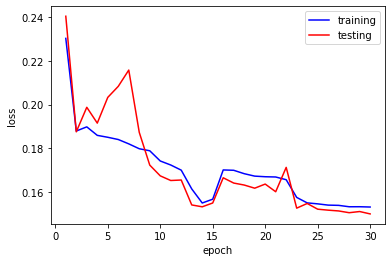

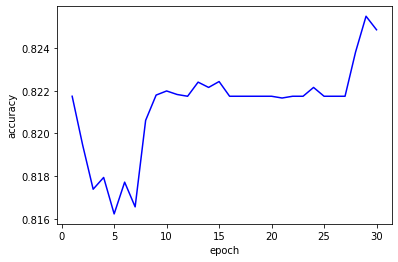

No handles with labels found to put in legend.


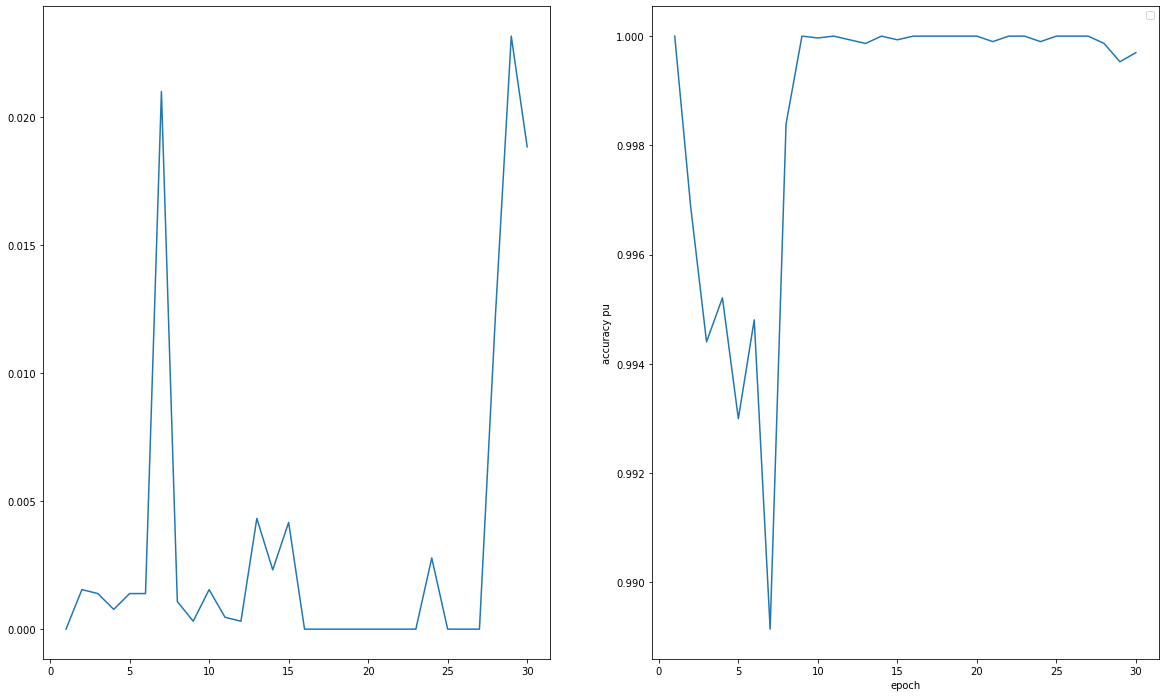

  2%|▏         | 4/168 [00:00<00:04, 39.26it/s]

epoch: 31


  7%|▋         | 3/42 [00:00<00:01, 23.14it/s]

batches for train: 168
train loss: 0.15306579481278146


  1%|          | 2/168 [00:00<00:08, 19.45it/s]

test total acc, ele acc, pu acc: 0.8252346997770008 0.021003861003861004 0.9996984722594479
epoch: 32


  7%|▋         | 3/42 [00:00<00:01, 23.11it/s]

batches for train: 168
train loss: 0.15294367979679788


  2%|▏         | 3/168 [00:00<00:05, 29.76it/s]

test total acc, ele acc, pu acc: 0.8277675302150153 0.03737451737451737 0.9992294291074779
epoch: 33


  7%|▋         | 3/42 [00:00<00:01, 23.01it/s]

batches for train: 168
train loss: 0.1529501455259465


  1%|          | 2/168 [00:00<00:08, 19.88it/s]

test total acc, ele acc, pu acc: 0.8274922225587094 0.035366795366795364 0.9993299383543286
epoch: 34


  7%|▋         | 3/42 [00:00<00:01, 22.86it/s]

batches for train: 168
train loss: 0.15272186306260882


  2%|▏         | 4/168 [00:00<00:05, 32.46it/s]

test total acc, ele acc, pu acc: 0.8269140764804669 0.031969111969111966 0.9993634414366122
epoch: 35


  5%|▍         | 2/42 [00:00<00:02, 17.40it/s]

batches for train: 168
train loss: 0.15250577161177284


  2%|▏         | 3/168 [00:00<00:07, 22.11it/s]

test total acc, ele acc, pu acc: 0.8265286457616386 0.02888030888030888 0.9995644599303136
new best test loss: 0.14986801111981982
epoch: 36


  7%|▋         | 3/42 [00:00<00:01, 22.21it/s]

batches for train: 168
train loss: 0.15249316004060565


  4%|▎         | 6/168 [00:00<00:02, 54.06it/s]

test total acc, ele acc, pu acc: 0.8289513531371308 0.04525096525096525 0.9989614044492093
new best test loss: 0.14959984627507983
epoch: 37


  7%|▋         | 3/42 [00:00<00:01, 23.59it/s]

batches for train: 168
train loss: 0.1526015070932252


  3%|▎         | 5/168 [00:00<00:03, 45.38it/s]

test total acc, ele acc, pu acc: 0.8279602455744294 0.038455598455598455 0.9992294291074779
epoch: 38


  7%|▋         | 3/42 [00:00<00:01, 23.59it/s]

batches for train: 168
train loss: 0.15238856701623826


  3%|▎         | 5/168 [00:00<00:03, 45.18it/s]

test total acc, ele acc, pu acc: 0.8280153071056906 0.03876447876447876 0.9992294291074779
new best test loss: 0.14959781013783954
epoch: 39


  5%|▍         | 2/42 [00:00<00:02, 17.71it/s]

batches for train: 168
train loss: 0.15539713425650484


  2%|▏         | 4/168 [00:00<00:04, 36.10it/s]

test total acc, ele acc, pu acc: 0.8243812460424524 0.015289575289575289 0.9998994907531493
epoch: 40


  7%|▋         | 3/42 [00:00<00:01, 23.13it/s]

batches for train: 168
train loss: 0.15315732297798


100%|██████████| 42/42 [00:02<00:00, 18.26it/s]


test total acc, ele acc, pu acc: 0.8257577843239821 0.024555984555984556 0.9995644599303136


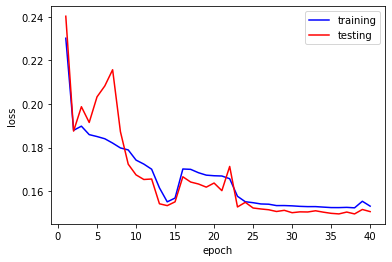

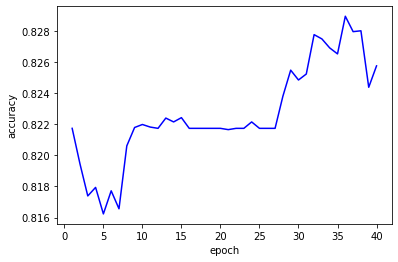

No handles with labels found to put in legend.


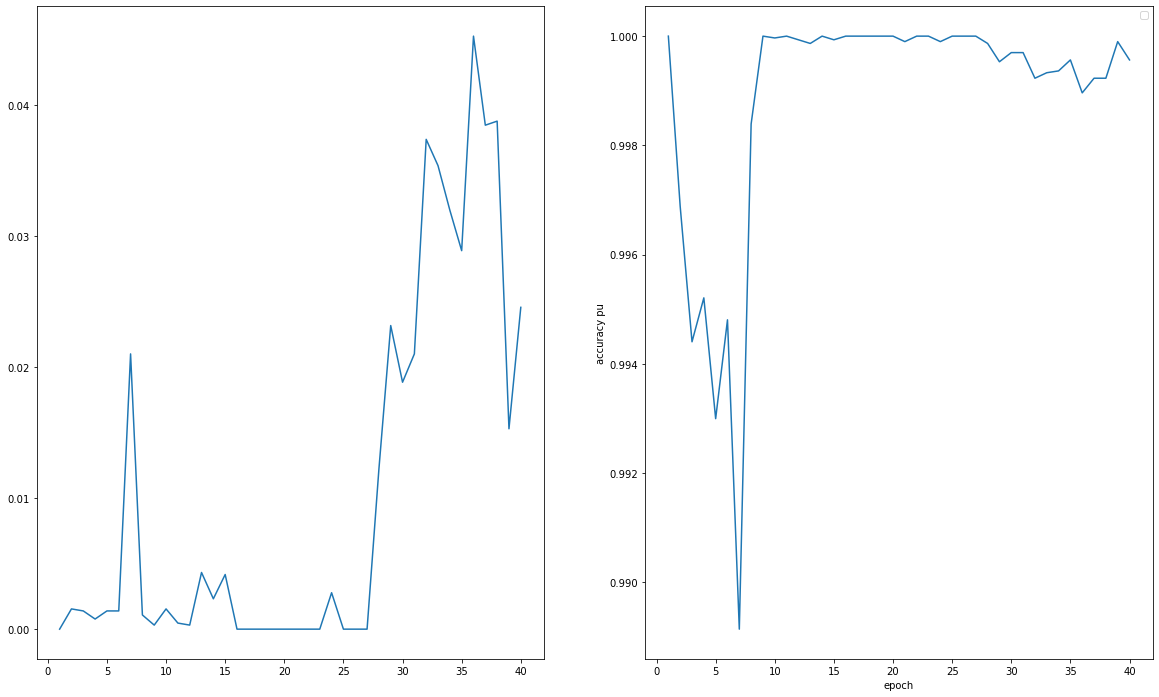

  2%|▏         | 4/168 [00:00<00:04, 35.91it/s]

epoch: 41


  5%|▍         | 2/42 [00:00<00:02, 19.36it/s]

batches for train: 168
train loss: 0.15273242142228854


  2%|▏         | 4/168 [00:00<00:04, 34.04it/s]

test total acc, ele acc, pu acc: 0.8263083996365939 0.02810810810810811 0.9994639506834628
epoch: 42


  7%|▋         | 3/42 [00:00<00:01, 23.17it/s]

batches for train: 168
train loss: 0.15243578711081118


  2%|▏         | 3/168 [00:00<00:05, 27.63it/s]

test total acc, ele acc, pu acc: 0.8288136993089777 0.04416988416988417 0.9990284106137765
new best test loss: 0.14939615804524647
epoch: 43


  7%|▋         | 3/42 [00:00<00:01, 22.30it/s]

batches for train: 168
train loss: 0.15267152268262135


  3%|▎         | 5/168 [00:00<00:03, 41.52it/s]

test total acc, ele acc, pu acc: 0.8257853150896126 0.023938223938223938 0.9997319753417314
epoch: 44


  7%|▋         | 3/42 [00:00<00:01, 23.08it/s]

batches for train: 168
train loss: 0.1538619642101583


  3%|▎         | 5/168 [00:00<00:03, 43.52it/s]

test total acc, ele acc, pu acc: 0.8278776532775376 0.0383011583011583 0.9991624229429108
epoch: 45


  7%|▋         | 3/42 [00:00<00:01, 23.10it/s]

batches for train: 168
train loss: 0.15369922295212746


  3%|▎         | 5/168 [00:00<00:03, 43.61it/s]

test total acc, ele acc, pu acc: 0.8268314841835751 0.03088803088803089 0.9994974537657465
epoch: 46


  7%|▋         | 3/42 [00:00<00:01, 23.50it/s]

batches for train: 168
train loss: 0.1633396562011469


  3%|▎         | 5/168 [00:00<00:03, 42.83it/s]

test total acc, ele acc, pu acc: 0.8217382925419155 0.0 1.0
epoch: 47


  7%|▋         | 3/42 [00:00<00:01, 23.07it/s]

batches for train: 168
train loss: 0.15554588092934518


  3%|▎         | 5/168 [00:00<00:03, 44.68it/s]

test total acc, ele acc, pu acc: 0.8231698923547064 0.008494208494208495 0.9998994907531493
epoch: 48


  7%|▋         | 3/42 [00:00<00:01, 23.19it/s]

batches for train: 168
train loss: 0.15604951773725806


  2%|▏         | 4/168 [00:00<00:04, 36.51it/s]

test total acc, ele acc, pu acc: 0.8220961924951133 0.002007722007722008 1.0
epoch: 49


  5%|▍         | 2/42 [00:00<00:02, 18.40it/s]

batches for train: 168
train loss: 0.1543865536472627


  2%|▏         | 4/168 [00:00<00:04, 38.13it/s]

test total acc, ele acc, pu acc: 0.8280978994025824 0.03984555984555985 0.9990954167783436
epoch: 50


  5%|▍         | 2/42 [00:00<00:02, 18.35it/s]

batches for train: 168
train loss: 0.15819024569576695


100%|██████████| 42/42 [00:02<00:00, 18.66it/s]


test total acc, ele acc, pu acc: 0.8217382925419155 0.0 1.0


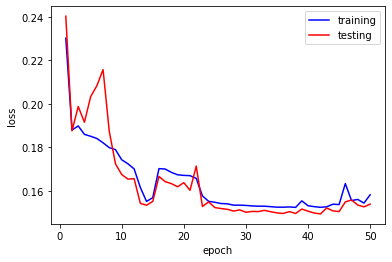

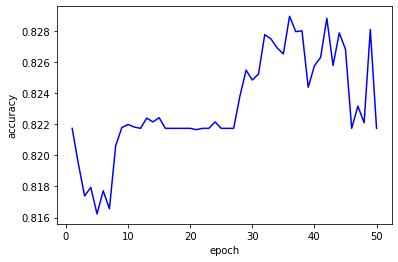

No handles with labels found to put in legend.


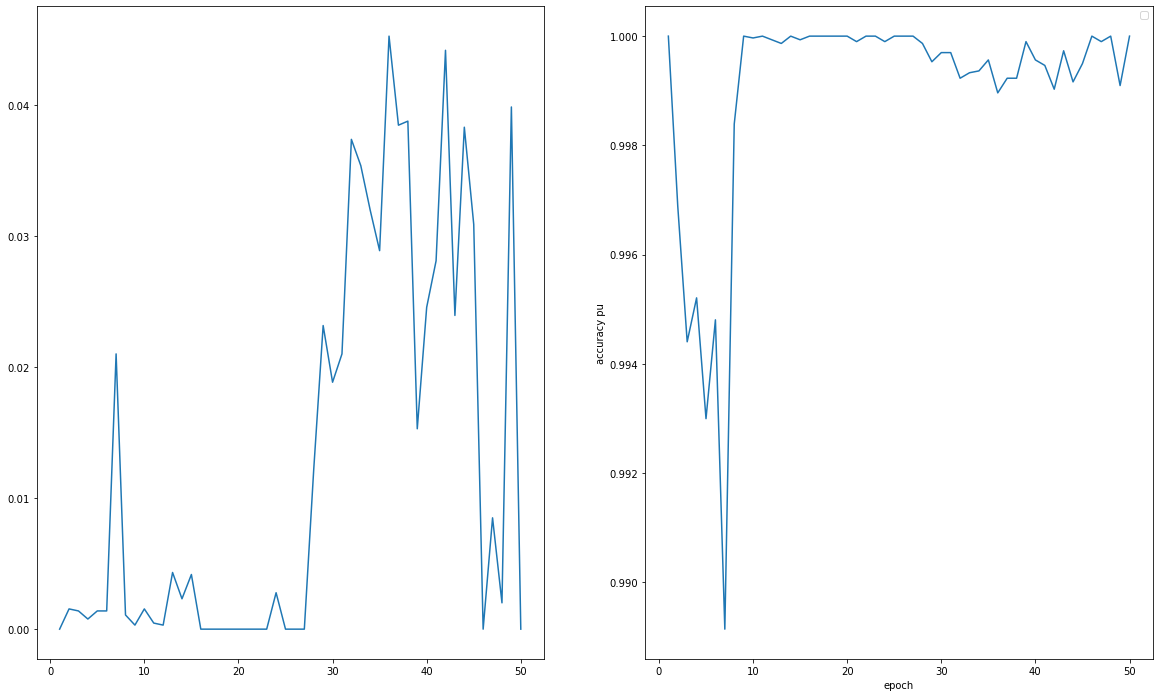

  2%|▏         | 4/168 [00:00<00:04, 38.45it/s]

epoch: 51


  5%|▍         | 2/42 [00:00<00:02, 18.60it/s]

batches for train: 168
train loss: 0.15517871880105563


  2%|▏         | 4/168 [00:00<00:04, 37.31it/s]

test total acc, ele acc, pu acc: 0.8219034771356991 0.0009266409266409266 1.0
epoch: 52


  5%|▍         | 2/42 [00:00<00:02, 17.89it/s]

batches for train: 168
train loss: 0.1540714747139386


  2%|▏         | 3/168 [00:00<00:06, 26.66it/s]

test total acc, ele acc, pu acc: 0.8268590149492058 0.03166023166023166 0.9993634414366122
epoch: 53


  7%|▋         | 3/42 [00:00<00:01, 23.28it/s]

batches for train: 168
train loss: 0.15633143058844975


  3%|▎         | 5/168 [00:00<00:03, 45.39it/s]

test total acc, ele acc, pu acc: 0.8267213611210528 0.030424710424710424 0.9994639506834628
epoch: 54


  7%|▋         | 3/42 [00:00<00:01, 23.01it/s]

batches for train: 168
train loss: 0.15464691454101176


  3%|▎         | 5/168 [00:00<00:03, 43.80it/s]

test total acc, ele acc, pu acc: 0.8250419844175867 0.01945945945945946 0.9997989815062985
epoch: 55


  7%|▋         | 3/42 [00:00<00:01, 22.27it/s]

batches for train: 168
train loss: 0.15354109524438778


  2%|▏         | 3/168 [00:00<00:06, 24.03it/s]

test total acc, ele acc, pu acc: 0.827244445668034 0.034594594594594595 0.9991959260251944
new best test loss: 0.14933289906808309
epoch: 56


  7%|▋         | 3/42 [00:00<00:01, 22.91it/s]

batches for train: 168
train loss: 0.15372235718227567


  2%|▏         | 4/168 [00:00<00:04, 33.56it/s]

test total acc, ele acc, pu acc: 0.8262533381053327 0.028262548262548263 0.9993634414366122
epoch: 57


  7%|▋         | 3/42 [00:00<00:01, 21.85it/s]

batches for train: 168
train loss: 0.15340213725964227


  2%|▏         | 4/168 [00:00<00:04, 36.66it/s]

test total acc, ele acc, pu acc: 0.8276849379181235 0.036756756756756756 0.9992629321897615
epoch: 58


  7%|▋         | 3/42 [00:00<00:01, 23.11it/s]

batches for train: 168
train loss: 0.15608377745818525


  2%|▏         | 3/168 [00:00<00:06, 24.60it/s]

test total acc, ele acc, pu acc: 0.8235277923079041 0.010501930501930502 0.9998994907531493
epoch: 59


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 0.15458367330332598


  3%|▎         | 5/168 [00:00<00:03, 43.06it/s]

test total acc, ele acc, pu acc: 0.8272169149024035 0.03428571428571429 0.9992294291074779
epoch: 60


  7%|▋         | 3/42 [00:00<00:01, 23.21it/s]

batches for train: 168
train loss: 0.15384139936594737


100%|██████████| 42/42 [00:02<00:00, 19.83it/s]


test total acc, ele acc, pu acc: 0.8255925997301985 0.023938223938223938 0.9994974537657465


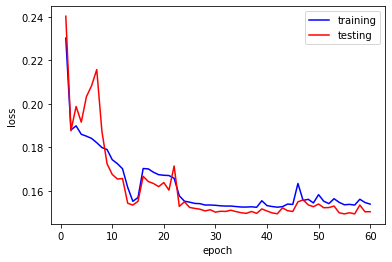

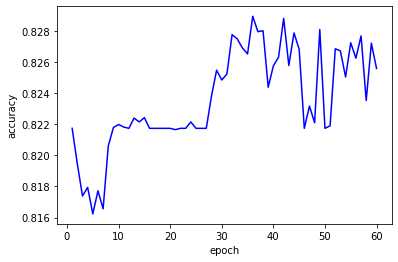

No handles with labels found to put in legend.


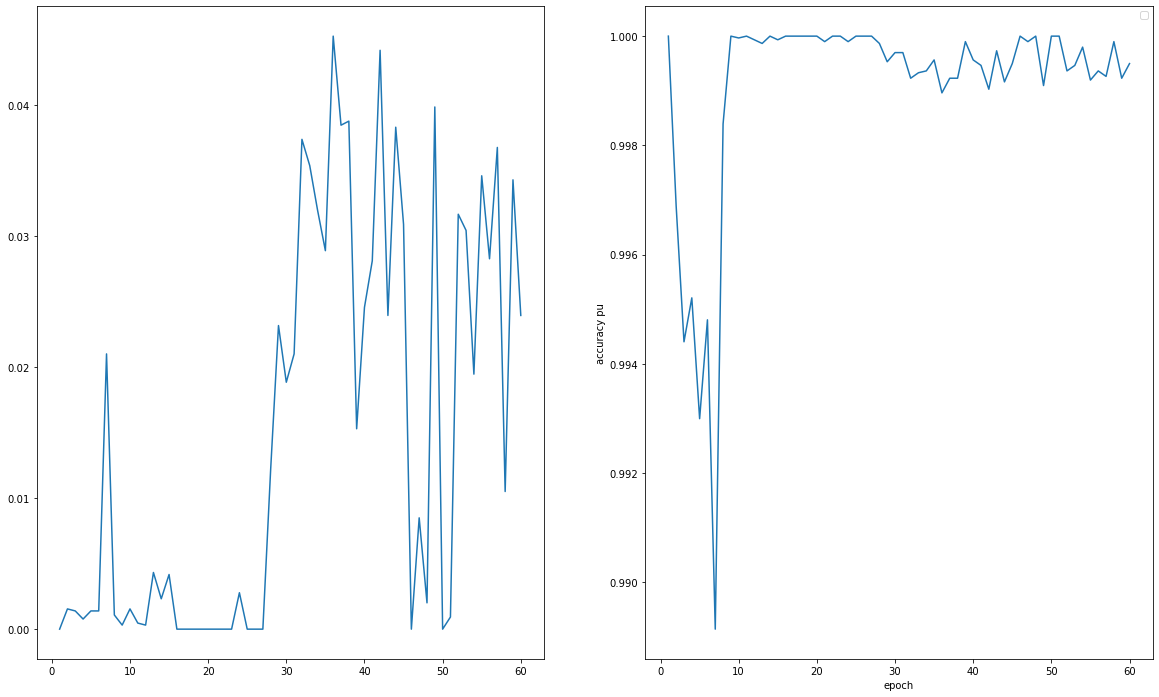

  3%|▎         | 5/168 [00:00<00:03, 41.57it/s]

epoch: 61


  7%|▋         | 3/42 [00:00<00:01, 22.73it/s]

batches for train: 168
train loss: 0.15381949944865136


  3%|▎         | 5/168 [00:00<00:03, 49.24it/s]

test total acc, ele acc, pu acc: 0.8269691380117281 0.03274131274131274 0.9992629321897615
epoch: 62


  7%|▋         | 3/42 [00:00<00:01, 23.11it/s]

batches for train: 168
train loss: 0.15361125115305185


  3%|▎         | 5/168 [00:00<00:03, 46.19it/s]

test total acc, ele acc, pu acc: 0.825014453651956 0.020077220077220077 0.9996314660948807
epoch: 63


  7%|▋         | 3/42 [00:00<00:01, 23.03it/s]

batches for train: 168
train loss: 0.16612379669788338


  3%|▎         | 5/168 [00:00<00:03, 41.96it/s]

test total acc, ele acc, pu acc: 0.8219034771356991 0.001081081081081081 0.9999664969177164
epoch: 64


  7%|▋         | 3/42 [00:00<00:01, 23.61it/s]

batches for train: 168
train loss: 0.15418595687619277


  3%|▎         | 5/168 [00:00<00:03, 49.80it/s]

test total acc, ele acc, pu acc: 0.8270241995429893 0.03335907335907336 0.9991959260251944
new best test loss: 0.14903142462883676
epoch: 65


  7%|▋         | 3/42 [00:00<00:01, 23.96it/s]

batches for train: 168
train loss: 0.1621631882375195


  2%|▏         | 4/168 [00:00<00:05, 31.97it/s]

test total acc, ele acc, pu acc: 0.8217382925419155 0.0 1.0
epoch: 66


  7%|▋         | 3/42 [00:00<00:01, 23.44it/s]

batches for train: 168
train loss: 0.1718477900361731


  2%|▏         | 3/168 [00:00<00:07, 23.07it/s]

test total acc, ele acc, pu acc: 0.8217382925419155 0.0 1.0
epoch: 67


  7%|▋         | 3/42 [00:00<00:01, 22.92it/s]

batches for train: 168
train loss: 0.17019100824282282


  2%|▏         | 4/168 [00:00<00:04, 33.43it/s]

test total acc, ele acc, pu acc: 0.8216832310106544 0.0 0.9999329938354329
epoch: 68


  7%|▋         | 3/42 [00:00<00:01, 22.63it/s]

batches for train: 168
train loss: 0.16950145283980028


  2%|▏         | 3/168 [00:00<00:06, 24.28it/s]

test total acc, ele acc, pu acc: 0.8217382925419155 0.0 1.0
epoch: 69


  7%|▋         | 3/42 [00:00<00:01, 23.46it/s]

batches for train: 168
train loss: 0.16894041117103326


  2%|▏         | 3/168 [00:00<00:06, 26.07it/s]

test total acc, ele acc, pu acc: 0.8219585386669603 0.0015444015444015444 0.9999329938354329
epoch: 70


  7%|▋         | 3/42 [00:00<00:01, 23.61it/s]

batches for train: 168
train loss: 0.16849479930741446


100%|██████████| 42/42 [00:02<00:00, 19.69it/s]


test total acc, ele acc, pu acc: 0.8222063155576357 0.003397683397683398 0.9998324845885822


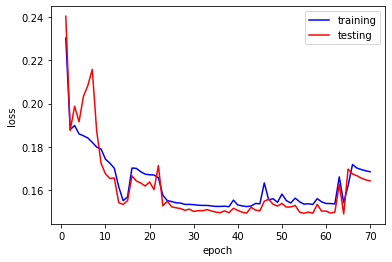

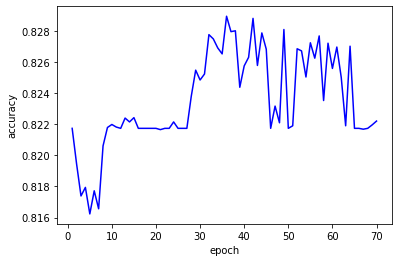

No handles with labels found to put in legend.


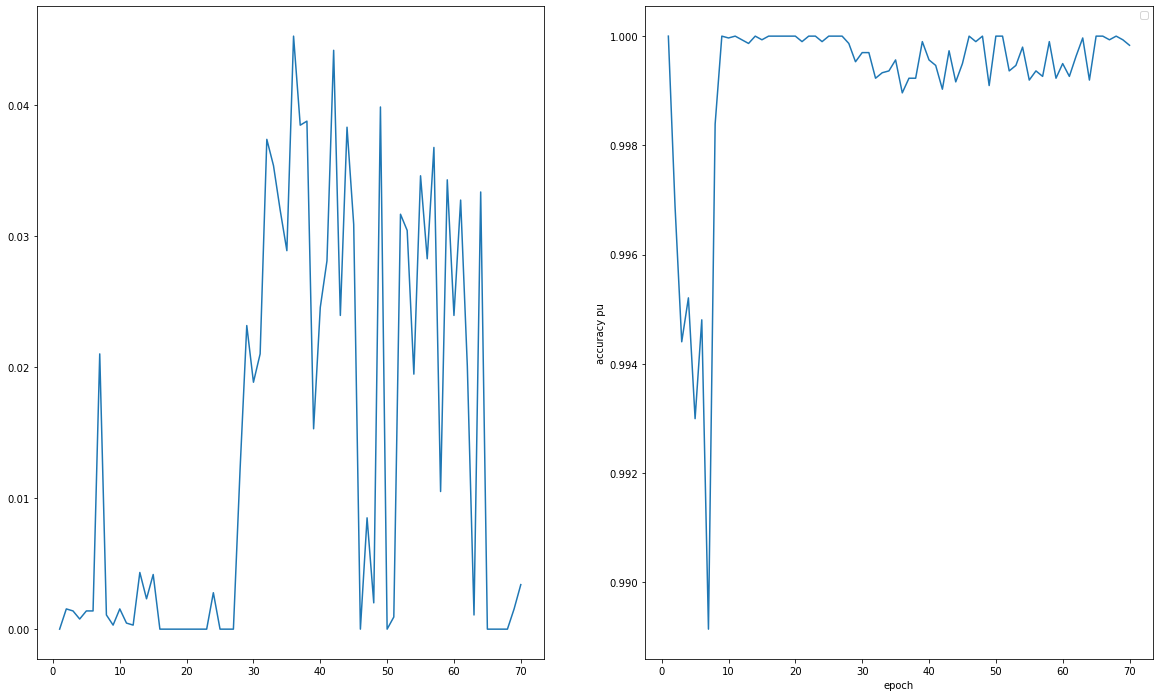

  2%|▏         | 4/168 [00:00<00:04, 39.33it/s]

epoch: 71


  7%|▋         | 3/42 [00:00<00:01, 22.80it/s]

batches for train: 168
train loss: 0.16791177869197868


  3%|▎         | 5/168 [00:00<00:03, 41.58it/s]

test total acc, ele acc, pu acc: 0.8216281694793932 0.0 0.9998659876708658
epoch: 72


  7%|▋         | 3/42 [00:00<00:01, 23.02it/s]

batches for train: 168
train loss: 0.16744493568936983


  2%|▏         | 3/168 [00:00<00:06, 25.54it/s]

test total acc, ele acc, pu acc: 0.8217382925419155 0.0006177606177606178 0.9998659876708658
epoch: 73


  7%|▋         | 3/42 [00:00<00:01, 23.40it/s]

batches for train: 168
train loss: 0.16638041181223734


  2%|▏         | 3/168 [00:00<00:06, 26.53it/s]

test total acc, ele acc, pu acc: 0.8217382925419155 0.0 1.0
epoch: 74


  5%|▍         | 2/42 [00:00<00:02, 17.54it/s]

batches for train: 168
train loss: 0.1662299996685414


  2%|▏         | 3/168 [00:00<00:06, 25.24it/s]

test total acc, ele acc, pu acc: 0.8217658233075462 0.00015444015444015445 1.0
epoch: 75


  7%|▋         | 3/42 [00:00<00:01, 22.98it/s]

batches for train: 168
train loss: 0.16552302862207094


  2%|▏         | 4/168 [00:00<00:04, 35.14it/s]

test total acc, ele acc, pu acc: 0.821710761776285 0.00015444015444015445 0.9999329938354329
epoch: 76


  7%|▋         | 3/42 [00:00<00:01, 21.98it/s]

batches for train: 168
train loss: 0.16540034319318475


  2%|▏         | 3/168 [00:00<00:06, 25.00it/s]

test total acc, ele acc, pu acc: 0.821848415604438 0.0007722007722007722 0.9999664969177164
epoch: 77


  7%|▋         | 3/42 [00:00<00:01, 23.51it/s]

batches for train: 168
train loss: 0.16514803362744196


  3%|▎         | 5/168 [00:00<00:03, 42.83it/s]

test total acc, ele acc, pu acc: 0.8228670539327698 0.0069498069498069494 0.9998659876708658
epoch: 78


  7%|▋         | 3/42 [00:00<00:01, 23.81it/s]

batches for train: 168
train loss: 0.16500796280091717


  2%|▏         | 3/168 [00:00<00:07, 23.39it/s]

test total acc, ele acc, pu acc: 0.8218759463700686 0.0009266409266409266 0.9999664969177164
epoch: 79


  7%|▋         | 3/42 [00:00<00:01, 23.00it/s]

batches for train: 168
train loss: 0.165045812992113


  3%|▎         | 5/168 [00:00<00:03, 42.09it/s]

test total acc, ele acc, pu acc: 0.8228119924015087 0.007413127413127413 0.9996984722594479
epoch: 80


  7%|▋         | 3/42 [00:00<00:01, 22.99it/s]

batches for train: 168
train loss: 0.16466834165510677


100%|██████████| 42/42 [00:02<00:00, 19.36it/s]


test total acc, ele acc, pu acc: 0.8222063155576357 0.003397683397683398 0.9998324845885822


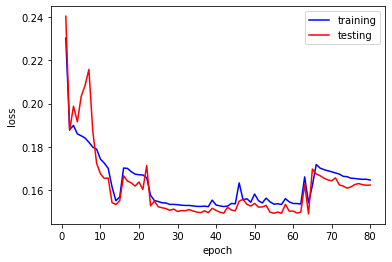

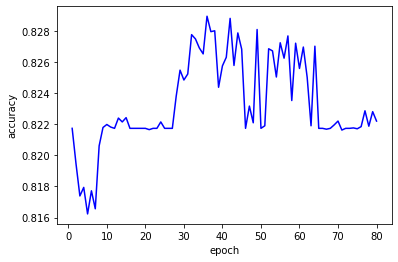

No handles with labels found to put in legend.


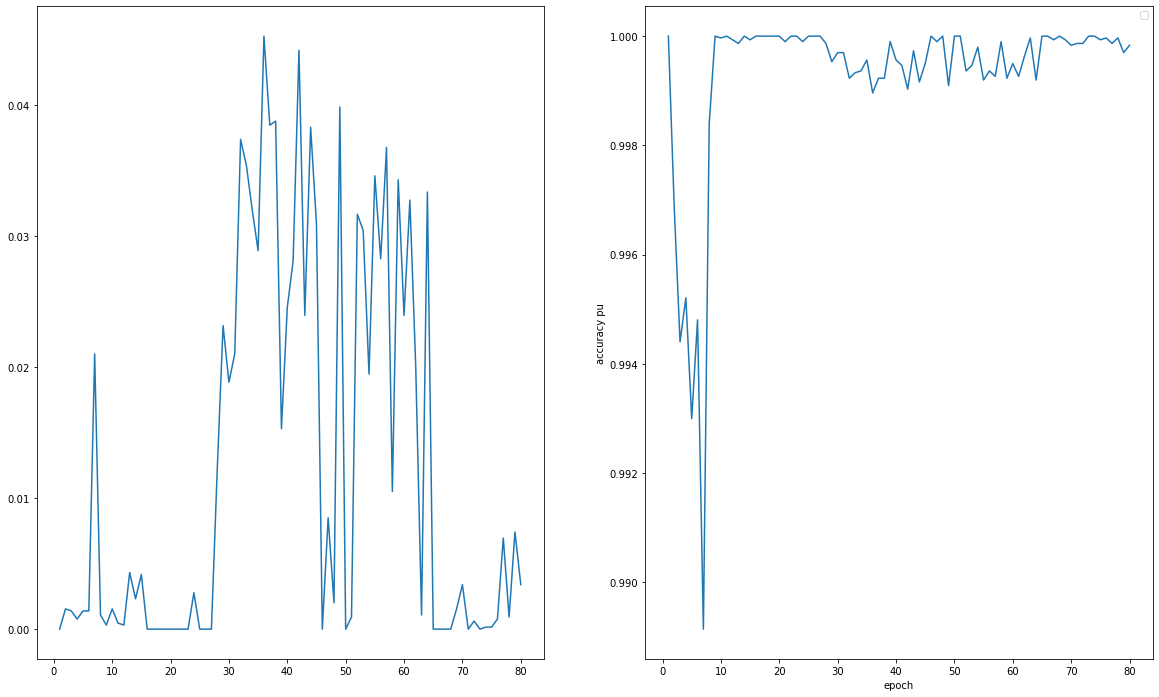

  3%|▎         | 5/168 [00:00<00:03, 42.92it/s]

epoch: 81


  5%|▍         | 2/42 [00:00<00:03, 12.41it/s]

batches for train: 168
train loss: 0.16436955226319178


  3%|▎         | 5/168 [00:00<00:03, 43.09it/s]

test total acc, ele acc, pu acc: 0.8242711229799301 0.01637065637065637 0.9995309568480301
epoch: 82


  7%|▋         | 3/42 [00:00<00:01, 23.14it/s]

batches for train: 168
train loss: 0.16435605571383521


  3%|▎         | 5/168 [00:00<00:03, 47.58it/s]

test total acc, ele acc, pu acc: 0.826776422652314 0.033667953667953665 0.9988273921200751
epoch: 83


  7%|▋         | 3/42 [00:00<00:01, 23.36it/s]

batches for train: 168
train loss: 0.1645302533039025


  3%|▎         | 5/168 [00:00<00:03, 49.21it/s]

test total acc, ele acc, pu acc: 0.8227569308702475 0.007104247104247104 0.9996984722594479
epoch: 84


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 0.16405625605867022


  3%|▎         | 5/168 [00:00<00:03, 42.93it/s]

test total acc, ele acc, pu acc: 0.8220411309638521 0.002007722007722008 0.9999329938354329
epoch: 85


  7%|▋         | 3/42 [00:00<00:01, 22.52it/s]

batches for train: 168
train loss: 0.1641312525385902


  3%|▎         | 5/168 [00:00<00:03, 43.68it/s]

test total acc, ele acc, pu acc: 0.8228119924015087 0.007258687258687259 0.9997319753417314
epoch: 86


  7%|▋         | 3/42 [00:00<00:01, 22.43it/s]

batches for train: 168
train loss: 0.1645436052765165


  2%|▏         | 4/168 [00:00<00:04, 35.39it/s]

test total acc, ele acc, pu acc: 0.8277950609806459 0.04030888030888031 0.9986263736263736
epoch: 87


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 0.1639338643068359


  2%|▏         | 3/168 [00:00<00:06, 24.65it/s]

test total acc, ele acc, pu acc: 0.823197423120337 0.010810810810810811 0.9994304476011793
epoch: 88


  5%|▍         | 2/42 [00:00<00:02, 17.92it/s]

batches for train: 168
train loss: 0.16392675272765614


  2%|▏         | 3/168 [00:00<00:06, 24.38it/s]

test total acc, ele acc, pu acc: 0.8244638383393442 0.01806949806949807 0.9993969445188957
epoch: 89


  7%|▋         | 3/42 [00:00<00:01, 23.02it/s]

batches for train: 168
train loss: 0.1638186029380276


  2%|▏         | 3/168 [00:00<00:06, 24.85it/s]

test total acc, ele acc, pu acc: 0.8242160614486689 0.016216216216216217 0.9994974537657465
epoch: 90


  7%|▋         | 3/42 [00:00<00:01, 23.49it/s]

batches for train: 168
train loss: 0.16438120958350955


100%|██████████| 42/42 [00:02<00:00, 17.42it/s]


test total acc, ele acc, pu acc: 0.8244638383393442 0.017915057915057916 0.9994304476011793


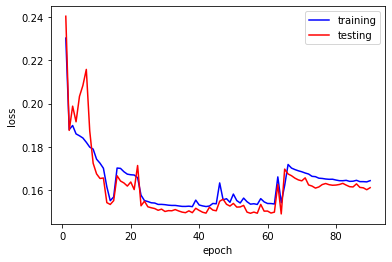

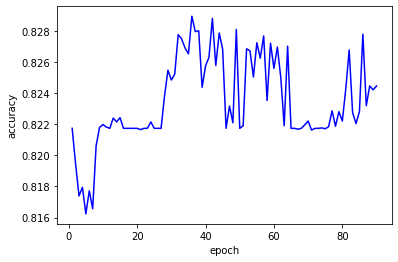

No handles with labels found to put in legend.


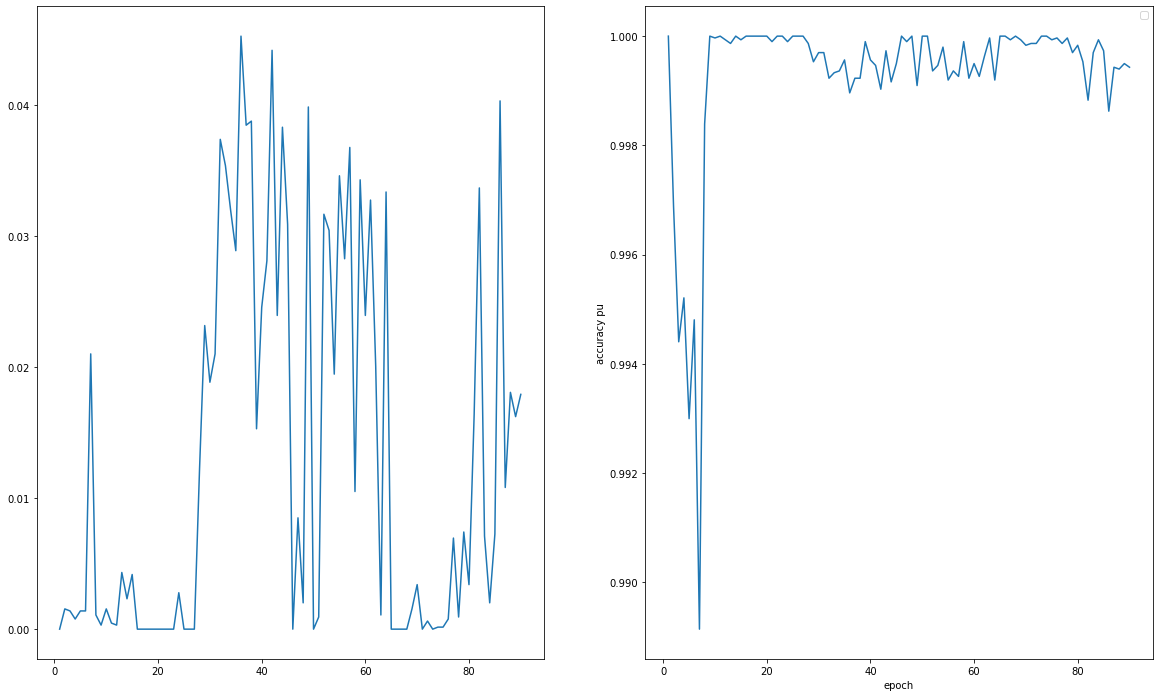

  3%|▎         | 5/168 [00:00<00:03, 42.20it/s]

epoch: 91


  7%|▋         | 3/42 [00:00<00:01, 23.47it/s]

batches for train: 168
train loss: 0.16458000171752202


  3%|▎         | 5/168 [00:00<00:03, 43.36it/s]

test total acc, ele acc, pu acc: 0.8223439693857886 0.004324324324324324 0.9997989815062985
epoch: 92


  7%|▋         | 3/42 [00:00<00:01, 22.84it/s]

batches for train: 168
train loss: 0.16427933566627048


  3%|▎         | 5/168 [00:00<00:03, 41.64it/s]

test total acc, ele acc, pu acc: 0.822178784792005 0.0029343629343629345 0.9998994907531493
epoch: 93


  7%|▋         | 3/42 [00:00<00:01, 22.82it/s]

batches for train: 168
train loss: 0.16374768689274788


  2%|▏         | 3/168 [00:00<00:05, 27.97it/s]

test total acc, ele acc, pu acc: 0.8230873000578146 0.009111969111969112 0.9996649691771643
epoch: 94


  7%|▋         | 3/42 [00:00<00:01, 23.35it/s]

batches for train: 168
train loss: 0.16393790819815227


  3%|▎         | 5/168 [00:00<00:03, 46.56it/s]

test total acc, ele acc, pu acc: 0.8228119924015087 0.007104247104247104 0.999765478424015
epoch: 95


  7%|▋         | 3/42 [00:00<00:01, 22.27it/s]

batches for train: 168
train loss: 0.16406494343564623


  2%|▏         | 3/168 [00:00<00:06, 25.62it/s]

test total acc, ele acc, pu acc: 0.8232800154172287 0.00972972972972973 0.999765478424015
epoch: 96


  7%|▋         | 3/42 [00:00<00:01, 22.77it/s]

batches for train: 168
train loss: 0.16368469161291918


  3%|▎         | 5/168 [00:00<00:03, 42.19it/s]

test total acc, ele acc, pu acc: 0.8227018693389864 0.005868725868725869 0.9998994907531493
epoch: 97


  7%|▋         | 3/42 [00:00<00:01, 22.14it/s]

batches for train: 168
train loss: 0.163651905244305


  2%|▏         | 4/168 [00:00<00:04, 35.55it/s]

test total acc, ele acc, pu acc: 0.8217658233075462 0.00015444015444015445 1.0
epoch: 98


  5%|▍         | 2/42 [00:00<00:02, 18.00it/s]

batches for train: 168
train loss: 0.16339645046918166


  2%|▏         | 3/168 [00:00<00:06, 24.07it/s]

test total acc, ele acc, pu acc: 0.825014453651956 0.021158301158301158 0.9993969445188957
epoch: 99


  7%|▋         | 3/42 [00:00<00:01, 23.26it/s]

batches for train: 168
train loss: 0.165142094095548


  2%|▏         | 4/168 [00:00<00:04, 38.05it/s]

test total acc, ele acc, pu acc: 0.8255925997301985 0.025637065637065637 0.9991289198606271
epoch: 100


  5%|▍         | 2/42 [00:00<00:02, 17.65it/s]

batches for train: 168
train loss: 0.164162440225482


100%|██████████| 42/42 [00:02<00:00, 16.45it/s]


test total acc, ele acc, pu acc: 0.8225917462764639 0.0055598455598455596 0.9998324845885822


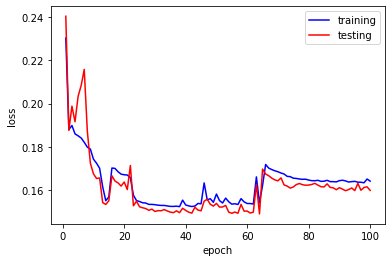

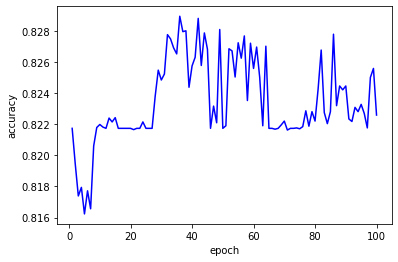

No handles with labels found to put in legend.


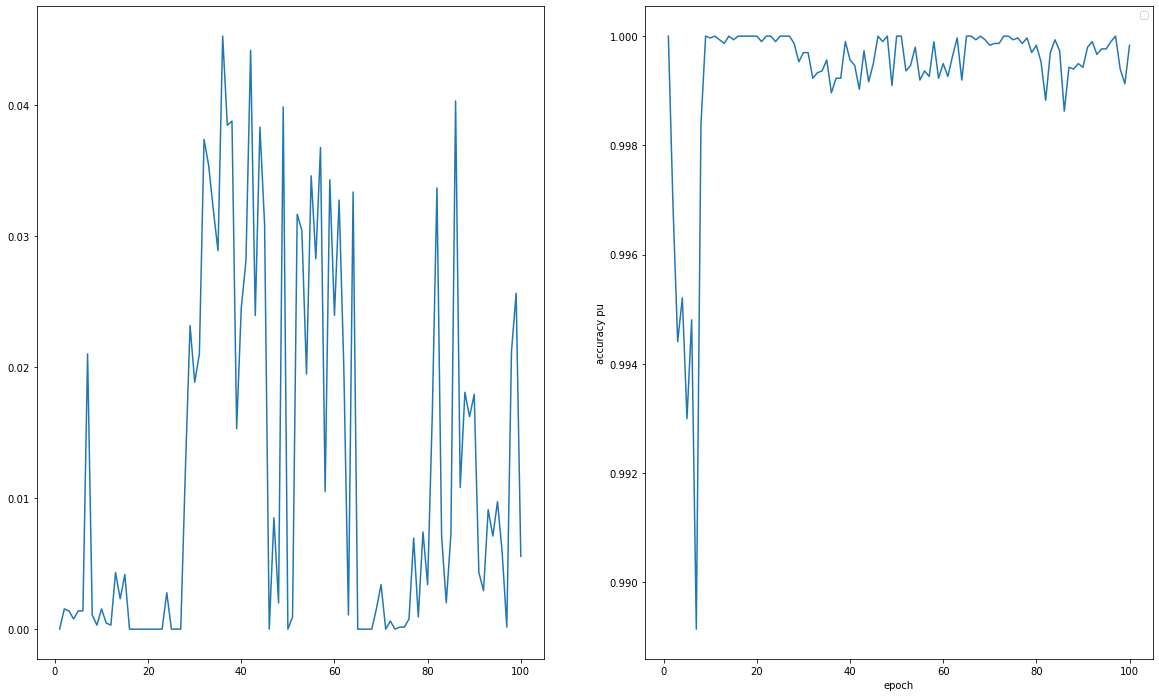

  3%|▎         | 5/168 [00:00<00:03, 42.53it/s]

epoch: 101


  7%|▋         | 3/42 [00:00<00:01, 23.58it/s]

batches for train: 168
train loss: 0.16345913841256074


  3%|▎         | 5/168 [00:00<00:03, 44.86it/s]

test total acc, ele acc, pu acc: 0.822316438620158 0.003243243243243243 1.0
epoch: 102


  7%|▋         | 3/42 [00:00<00:01, 22.69it/s]

batches for train: 168
train loss: 0.1633994032052301


  3%|▎         | 5/168 [00:00<00:03, 41.82it/s]

test total acc, ele acc, pu acc: 0.8217933540731768 0.0003088803088803089 1.0
epoch: 103


  7%|▋         | 3/42 [00:00<00:01, 23.22it/s]

batches for train: 168
train loss: 0.1631426921203023


  2%|▏         | 3/168 [00:00<00:06, 23.99it/s]

test total acc, ele acc, pu acc: 0.8218759463700686 0.0009266409266409266 0.9999664969177164
epoch: 104


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 0.16306365866746222


  2%|▏         | 3/168 [00:00<00:05, 27.78it/s]

test total acc, ele acc, pu acc: 0.8220686617294827 0.002007722007722008 0.9999664969177164
epoch: 105


  7%|▋         | 3/42 [00:00<00:01, 22.73it/s]

batches for train: 168
train loss: 0.1628429720266944


  2%|▏         | 4/168 [00:00<00:04, 39.30it/s]

test total acc, ele acc, pu acc: 0.8218759463700686 0.0009266409266409266 0.9999664969177164
epoch: 106


  7%|▋         | 3/42 [00:00<00:01, 22.72it/s]

batches for train: 168
train loss: 0.16286833069863774


  3%|▎         | 5/168 [00:00<00:03, 41.07it/s]

test total acc, ele acc, pu acc: 0.8223439693857886 0.00416988416988417 0.9998324845885822
epoch: 107


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 0.16269511534344583


  3%|▎         | 5/168 [00:00<00:03, 42.61it/s]

test total acc, ele acc, pu acc: 0.8231423615890758 0.008957528957528958 0.999765478424015
epoch: 108


  5%|▍         | 2/42 [00:00<00:02, 17.78it/s]

batches for train: 168
train loss: 0.16268468000704334


  2%|▏         | 4/168 [00:00<00:04, 38.39it/s]

test total acc, ele acc, pu acc: 0.8219034771356991 0.001081081081081081 0.9999664969177164
epoch: 109


  7%|▋         | 3/42 [00:00<00:01, 23.01it/s]

batches for train: 168
train loss: 0.1627726572610083


  3%|▎         | 5/168 [00:00<00:03, 48.58it/s]

test total acc, ele acc, pu acc: 0.8224265616826804 0.00416988416988417 0.9999329938354329
epoch: 110


  7%|▋         | 3/42 [00:00<00:01, 23.09it/s]

batches for train: 168
train loss: 0.1626288298340071


100%|██████████| 42/42 [00:02<00:00, 17.16it/s]


test total acc, ele acc, pu acc: 0.8230873000578146 0.008494208494208495 0.9997989815062985


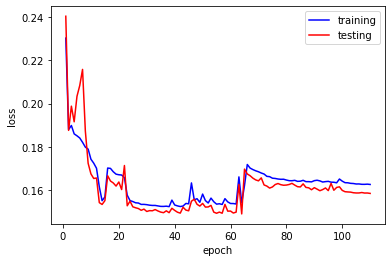

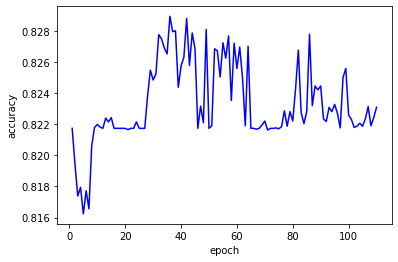

No handles with labels found to put in legend.


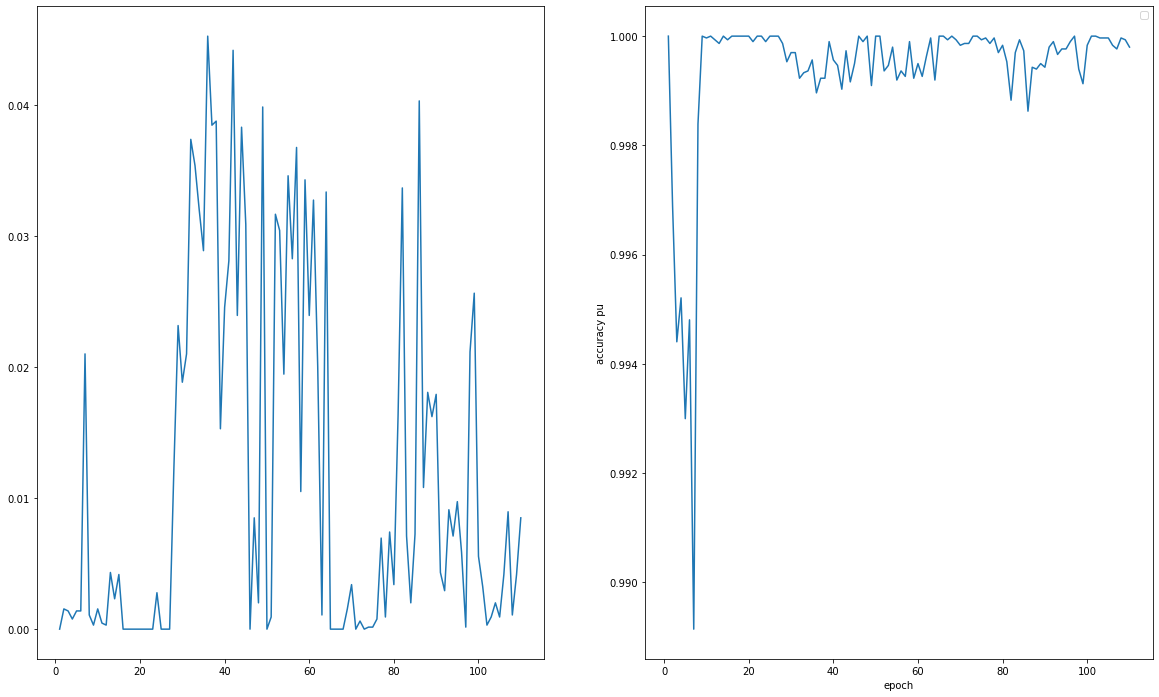

  3%|▎         | 5/168 [00:00<00:03, 44.22it/s]

epoch: 111


  7%|▋         | 3/42 [00:00<00:01, 22.81it/s]

batches for train: 168
train loss: 0.16266544792978538


  2%|▏         | 4/168 [00:00<00:05, 27.97it/s]

test total acc, ele acc, pu acc: 0.8222063155576357 0.0027799227799227798 0.9999664969177164
epoch: 112


  7%|▋         | 3/42 [00:00<00:01, 24.06it/s]

batches for train: 168
train loss: 0.16242668511612074


  2%|▏         | 4/168 [00:00<00:04, 38.04it/s]

test total acc, ele acc, pu acc: 0.822178784792005 0.0027799227799227798 0.9999329938354329
epoch: 113


  0%|          | 0/42 [00:00<?, ?it/s]

batches for train: 168
train loss: 0.1622470858551207


  3%|▎         | 5/168 [00:00<00:03, 42.35it/s]

test total acc, ele acc, pu acc: 0.8230047077609228 0.007876447876447876 0.9998324845885822
epoch: 114


  7%|▋         | 3/42 [00:00<00:01, 23.45it/s]

batches for train: 168
train loss: 0.16237978690436908


  3%|▎         | 5/168 [00:00<00:03, 41.02it/s]

test total acc, ele acc, pu acc: 0.8220686617294827 0.0023166023166023165 0.9998994907531493
epoch: 115


  7%|▋         | 3/42 [00:00<00:01, 23.31it/s]

batches for train: 168
train loss: 0.16233537958136626


  2%|▏         | 4/168 [00:00<00:05, 28.26it/s]

test total acc, ele acc, pu acc: 0.8219034771356991 0.0009266409266409266 1.0
epoch: 116


  5%|▍         | 2/42 [00:00<00:02, 18.06it/s]

batches for train: 168
train loss: 0.1623257767586481


  2%|▏         | 3/168 [00:00<00:06, 23.74it/s]

test total acc, ele acc, pu acc: 0.8224265616826804 0.00416988416988417 0.9999329938354329
epoch: 117


  7%|▋         | 3/42 [00:00<00:01, 22.90it/s]

batches for train: 168
train loss: 0.1623248104006052


  2%|▏         | 4/168 [00:00<00:04, 37.03it/s]

test total acc, ele acc, pu acc: 0.8223715001514192 0.003861003861003861 0.9999329938354329
epoch: 118


  5%|▍         | 2/42 [00:00<00:02, 18.04it/s]

batches for train: 168
train loss: 0.1620562363061167


  3%|▎         | 5/168 [00:00<00:03, 43.22it/s]

test total acc, ele acc, pu acc: 0.8225366847452028 0.004942084942084942 0.9998994907531493
epoch: 119


  7%|▋         | 3/42 [00:00<00:01, 23.24it/s]

batches for train: 168
train loss: 0.16192141370404334


  3%|▎         | 5/168 [00:00<00:03, 43.77it/s]

test total acc, ele acc, pu acc: 0.8226192770420946 0.0055598455598455596 0.9998659876708658
epoch: 120


  5%|▍         | 2/42 [00:00<00:02, 17.81it/s]

batches for train: 168
train loss: 0.16212166783710322


100%|██████████| 42/42 [00:02<00:00, 17.78it/s]


test total acc, ele acc, pu acc: 0.8230322385265534 0.008030888030888032 0.9998324845885822


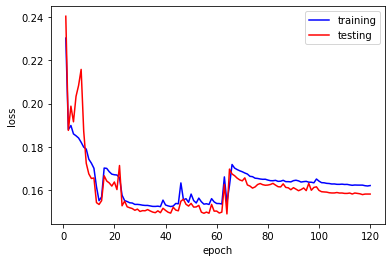

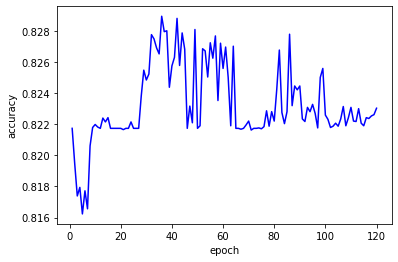

No handles with labels found to put in legend.


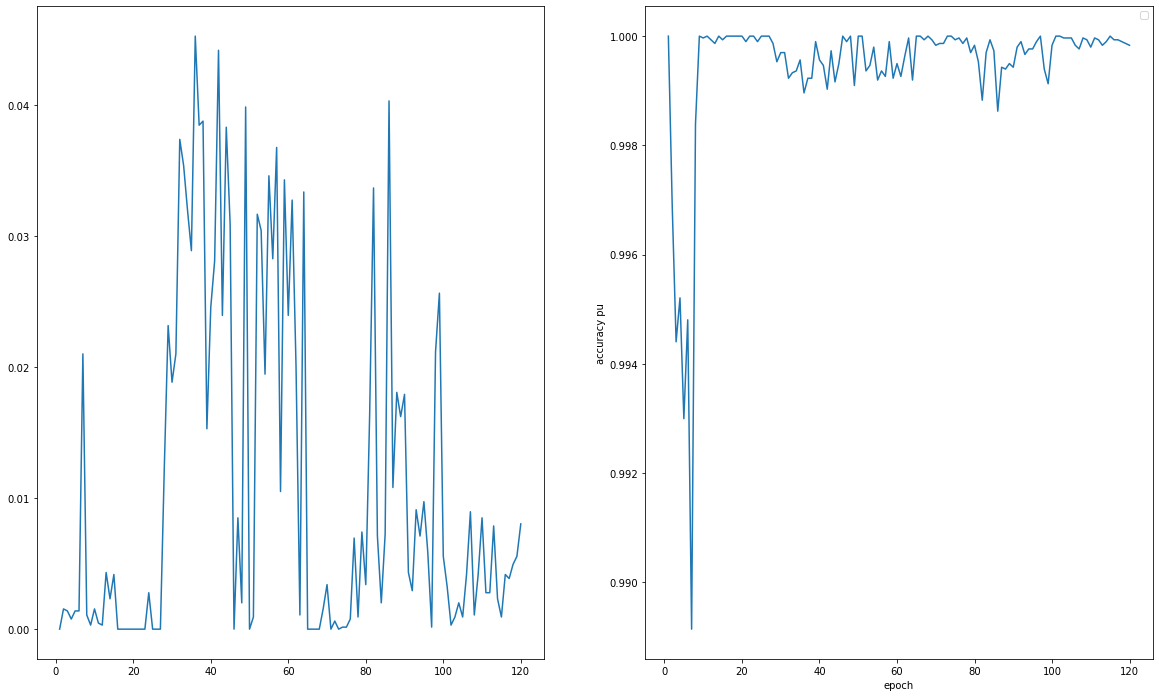

  2%|▏         | 4/168 [00:00<00:04, 38.81it/s]

epoch: 121


  7%|▋         | 3/42 [00:00<00:01, 23.01it/s]

batches for train: 168
train loss: 0.16188016622549012


  1%|          | 2/168 [00:00<00:08, 19.18it/s]

test total acc, ele acc, pu acc: 0.8236654461360571 0.012200772200772201 0.9996984722594479
epoch: 122


  7%|▋         | 3/42 [00:00<00:01, 22.95it/s]

batches for train: 168
train loss: 0.1619302337723119


  2%|▏         | 4/168 [00:00<00:05, 32.44it/s]

test total acc, ele acc, pu acc: 0.8226192770420946 0.005405405405405406 0.9998994907531493
epoch: 123


  5%|▍         | 2/42 [00:00<00:02, 17.97it/s]

batches for train: 168
train loss: 0.16199106403759547


  2%|▏         | 3/168 [00:00<00:06, 27.00it/s]

test total acc, ele acc, pu acc: 0.8232800154172287 0.009420849420849422 0.9998324845885822
epoch: 124


  7%|▋         | 3/42 [00:00<00:01, 22.89it/s]

batches for train: 168
train loss: 0.1617371637728952


  2%|▏         | 3/168 [00:00<00:06, 24.40it/s]

test total acc, ele acc, pu acc: 0.8222063155576357 0.0027799227799227798 0.9999664969177164
epoch: 125


  7%|▋         | 3/42 [00:00<00:01, 21.87it/s]

batches for train: 168
train loss: 0.16170720658486798


  3%|▎         | 5/168 [00:00<00:03, 44.57it/s]

test total acc, ele acc, pu acc: 0.8223990309170498 0.003861003861003861 0.9999664969177164
epoch: 126


  7%|▋         | 3/42 [00:00<00:01, 23.89it/s]

batches for train: 168
train loss: 0.16160176126729875


  2%|▏         | 3/168 [00:00<00:06, 23.74it/s]

test total acc, ele acc, pu acc: 0.8232249538859676 0.009111969111969112 0.9998324845885822
epoch: 127


  7%|▋         | 3/42 [00:00<00:01, 23.79it/s]

batches for train: 168
train loss: 0.16137646546676046


  2%|▏         | 4/168 [00:00<00:04, 39.65it/s]

test total acc, ele acc, pu acc: 0.8232524846515982 0.009420849420849422 0.9997989815062985
epoch: 128


  7%|▋         | 3/42 [00:00<00:01, 23.13it/s]

batches for train: 168
train loss: 0.16135217320351375


  3%|▎         | 5/168 [00:00<00:03, 41.54it/s]

test total acc, ele acc, pu acc: 0.8230322385265534 0.007722007722007722 0.9998994907531493
epoch: 129


  7%|▋         | 3/42 [00:00<00:01, 23.48it/s]

batches for train: 168
train loss: 0.16146515194504035


  3%|▎         | 5/168 [00:00<00:03, 41.71it/s]

test total acc, ele acc, pu acc: 0.8230047077609228 0.007876447876447876 0.9998324845885822
epoch: 130


  7%|▋         | 3/42 [00:00<00:01, 23.01it/s]

batches for train: 168
train loss: 0.16137208363839559


100%|██████████| 42/42 [00:02<00:00, 20.29it/s]


test total acc, ele acc, pu acc: 0.8233901384797512 0.010193050193050193 0.9997989815062985


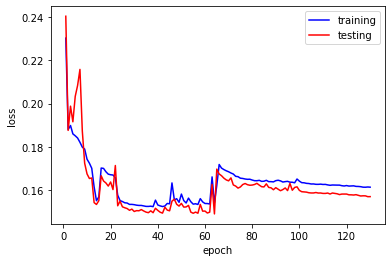

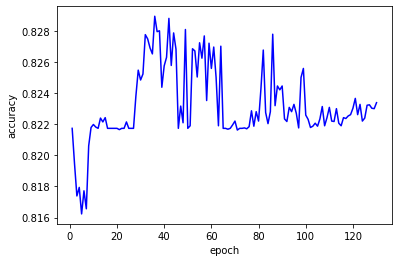

No handles with labels found to put in legend.


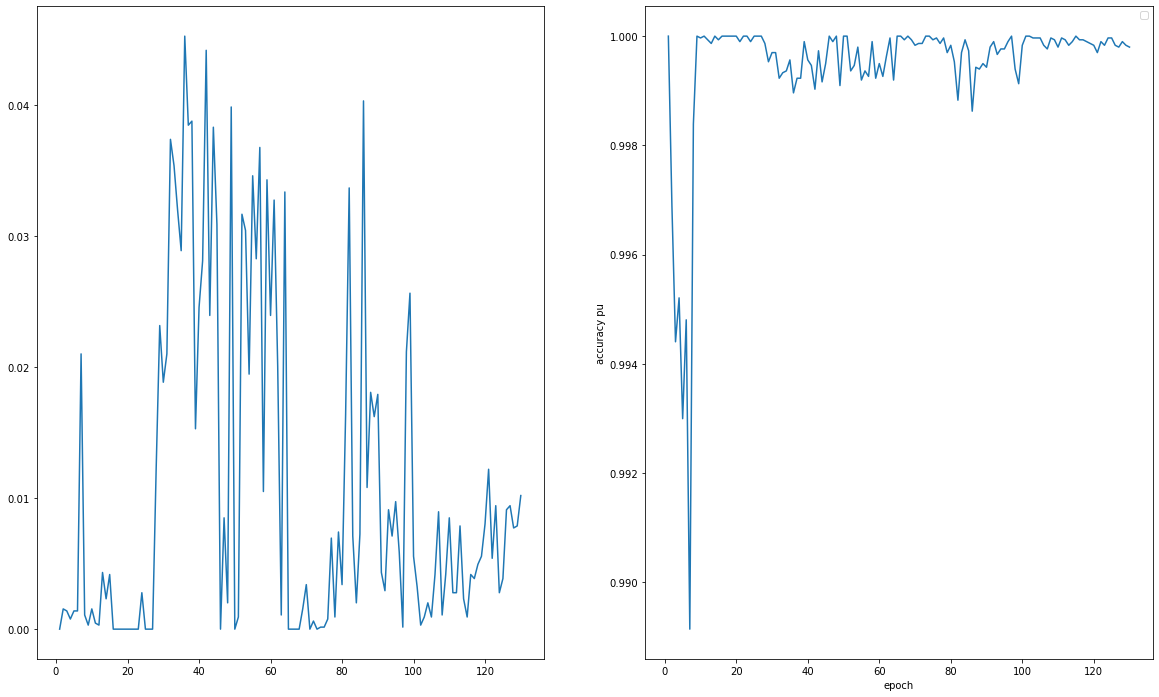

  2%|▏         | 4/168 [00:00<00:04, 34.04it/s]

epoch: 131


  7%|▋         | 3/42 [00:00<00:01, 23.54it/s]

batches for train: 168
train loss: 0.16129301931886447


  2%|▏         | 3/168 [00:00<00:06, 24.88it/s]

test total acc, ele acc, pu acc: 0.8239132230267324 0.013590733590733591 0.9996984722594479
epoch: 132


  7%|▋         | 3/42 [00:00<00:01, 23.08it/s]

batches for train: 168
train loss: 0.161178002932242


  2%|▏         | 3/168 [00:00<00:06, 24.95it/s]

test total acc, ele acc, pu acc: 0.8230322385265534 0.007876447876447876 0.9998659876708658
epoch: 133


  7%|▋         | 3/42 [00:00<00:01, 23.05it/s]

batches for train: 168
train loss: 0.1611888204656896


  2%|▏         | 3/168 [00:00<00:06, 24.52it/s]

test total acc, ele acc, pu acc: 0.8237480384329489 0.012509652509652509 0.9997319753417314
epoch: 134


  7%|▋         | 3/42 [00:00<00:01, 22.91it/s]

batches for train: 168
train loss: 0.1610597637260244


  2%|▏         | 3/168 [00:00<00:07, 20.75it/s]

test total acc, ele acc, pu acc: 0.8240784076205159 0.014671814671814672 0.9996649691771643
epoch: 135


  5%|▍         | 2/42 [00:00<00:02, 17.26it/s]

batches for train: 168
train loss: 0.16095490611734845


  2%|▏         | 3/168 [00:00<00:06, 27.13it/s]

test total acc, ele acc, pu acc: 0.8243537152768219 0.01637065637065637 0.9996314660948807
epoch: 136


  5%|▍         | 2/42 [00:00<00:02, 17.43it/s]

batches for train: 168
train loss: 0.16092531755566597


  4%|▎         | 6/168 [00:00<00:03, 53.15it/s]

test total acc, ele acc, pu acc: 0.8226743385733557 0.005868725868725869 0.9998659876708658
epoch: 137


  7%|▋         | 3/42 [00:00<00:01, 23.69it/s]

batches for train: 168
train loss: 0.16090951700295722


  3%|▎         | 5/168 [00:00<00:03, 42.50it/s]

test total acc, ele acc, pu acc: 0.8222889078545275 0.003243243243243243 0.9999664969177164
epoch: 138


  7%|▋         | 3/42 [00:00<00:01, 22.40it/s]

batches for train: 168
train loss: 0.16056238309968085


  2%|▏         | 3/168 [00:00<00:07, 23.12it/s]

test total acc, ele acc, pu acc: 0.8234452000110123 0.010501930501930502 0.9997989815062985
epoch: 139


  7%|▋         | 3/42 [00:00<00:01, 23.57it/s]

batches for train: 168
train loss: 0.16064987730767047


  2%|▏         | 4/168 [00:00<00:04, 37.22it/s]

test total acc, ele acc, pu acc: 0.823940753792363 0.013127413127413128 0.9998324845885822
epoch: 140


  5%|▍         | 2/42 [00:00<00:02, 18.22it/s]

batches for train: 168
train loss: 0.1605828824852194


100%|██████████| 42/42 [00:02<00:00, 18.52it/s]


test total acc, ele acc, pu acc: 0.8237480384329489 0.012200772200772201 0.9997989815062985


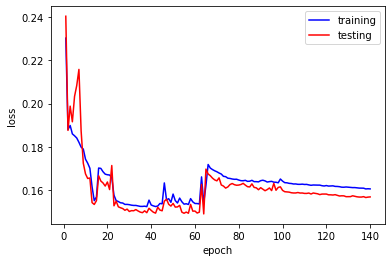

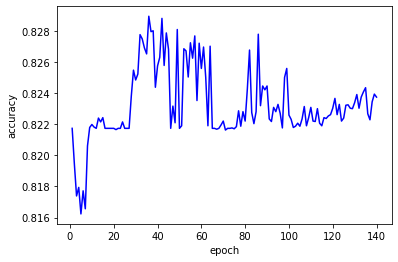

No handles with labels found to put in legend.


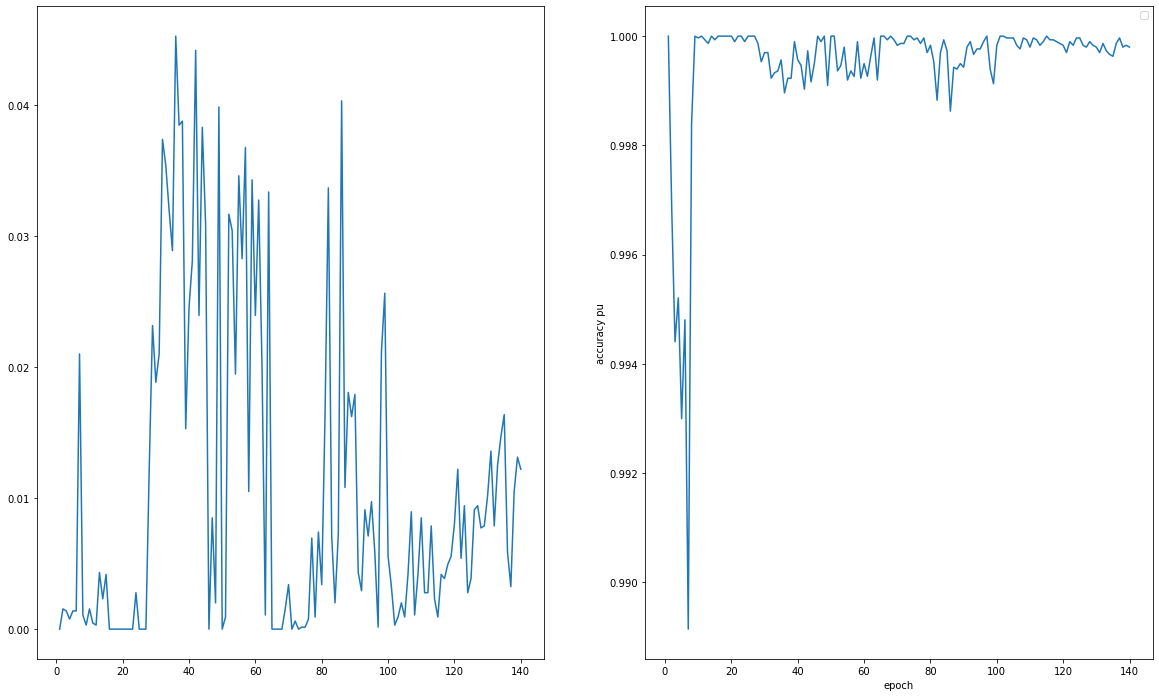

  3%|▎         | 5/168 [00:00<00:03, 43.43it/s]

epoch: 141


  5%|▍         | 2/42 [00:00<00:02, 18.52it/s]

batches for train: 168
train loss: 0.1607483754910174


  3%|▎         | 5/168 [00:00<00:03, 44.03it/s]

test total acc, ele acc, pu acc: 0.8234452000110123 0.010656370656370656 0.999765478424015
epoch: 142


  7%|▋         | 3/42 [00:00<00:01, 23.42it/s]

batches for train: 168
train loss: 0.1607697079224246


  3%|▎         | 5/168 [00:00<00:03, 49.73it/s]

test total acc, ele acc, pu acc: 0.8241334691517771 0.014517374517374518 0.999765478424015
epoch: 143


  7%|▋         | 3/42 [00:00<00:01, 22.91it/s]

batches for train: 168
train loss: 0.16765697069820903


  3%|▎         | 5/168 [00:00<00:03, 43.10it/s]

test total acc, ele acc, pu acc: 0.8242435922142994 0.015444015444015444 0.9996984722594479
epoch: 144


  7%|▋         | 3/42 [00:00<00:01, 23.75it/s]

batches for train: 168
train loss: 0.1618653613896597


  3%|▎         | 5/168 [00:00<00:03, 41.86it/s]

test total acc, ele acc, pu acc: 0.8264185226991163 0.029034749034749036 0.9993969445188957
epoch: 145


  7%|▋         | 3/42 [00:00<00:01, 23.07it/s]

batches for train: 168
train loss: 0.16160074665787674


  4%|▎         | 6/168 [00:00<00:03, 50.71it/s]

test total acc, ele acc, pu acc: 0.8262808688709633 0.02810810810810811 0.9994304476011793
epoch: 146


  7%|▋         | 3/42 [00:00<00:01, 23.29it/s]

batches for train: 168
train loss: 0.1610596595952908


  3%|▎         | 5/168 [00:00<00:03, 42.41it/s]

test total acc, ele acc, pu acc: 0.8254824766676762 0.02409266409266409 0.9993299383543286
epoch: 147


  7%|▋         | 3/42 [00:00<00:01, 22.79it/s]

batches for train: 168
train loss: 0.16095528849178836


  2%|▏         | 4/168 [00:00<00:04, 37.18it/s]

test total acc, ele acc, pu acc: 0.8243261845111912 0.01637065637065637 0.9995979630125972
epoch: 148


  5%|▍         | 2/42 [00:00<00:02, 17.13it/s]

batches for train: 168
train loss: 0.16229864147802195


  2%|▏         | 3/168 [00:00<00:06, 25.55it/s]

test total acc, ele acc, pu acc: 0.82333507694849 0.00972972972972973 0.9998324845885822
epoch: 149


 17%|█▋        | 29/168 [00:00<00:02, 47.30it/s]

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)


from tqdm import tqdm as tqdm
checkpoint_dir = '/home/llr/cms/sghosh/hackathonTICL/model_nodenetwork/'

os.makedirs(checkpoint_dir, exist_ok=True)
best_loss = 99999999
losst = []
lossv = []
epochs = []
acc = []
elc= []
puc = []


for epoch in range(1, 201):
    print ('epoch:',epoch)
    losst.append(train(epoch))
    loss_epoch,accuracy, eleacc, puacc = evaluate(epoch)
    lossv.append(loss_epoch)
    acc.append(accuracy)
    elc.append(eleacc)
    puc.append(puacc)
    epochs.append(epoch)
    print("test total acc, ele acc, pu acc:",accuracy,eleacc,puacc)
    checkpoint = {
    'epoch': epoch + 1,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
    }
    
    
    
    checkpoint_file = 'model_epoch_%i.pth.tar' % ( epoch )
    torch.save(checkpoint,
                   os.path.join(checkpoint_dir,checkpoint_file ))
    if loss_epoch < best_loss:
        best_loss = loss_epoch
        print('new best test loss:',best_loss)
        torch.save(checkpoint,
                   os.path.join(checkpoint_dir,'model_checkpoint_best.pth.tar' ))
    if (epoch%10 == 0):
        plt.plot(np.array(epochs),np.array(losst),c='b',label='training')
        plt.plot(np.array(epochs),np.array(lossv),c='r',label='testing')
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend()
        plt.savefig(checkpoint_dir+'loss_{0}.png'.format(epoch))
        plt.show()
        plt.plot(np.array(epochs),np.array(acc),c='b')
        plt.xlabel("epoch")
        plt.ylabel("accuracy")
        plt.savefig(checkpoint_dir+'acc_class_{0}.png'.format(epoch))
        plt.show()
        fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(20,12))
        ax0.plot(np.array(epochs),np.array(elc))#,label=str(etabinsG[i])+"_to_"+str(etabinsG[i+1]))
        ax1.set_xlabel("epoch")
        ax1.set_ylabel("accuracy ele")
        ax1.plot(np.array(epochs),np.array(puc))#,label=str(etabinsG[i])+"_to_"+str(etabinsG[i+1]))
        ax1.set_xlabel("epoch")
        ax1.set_ylabel("accuracy pu")
        plt.legend()
        plt.savefig(checkpoint_dir+'acc_class_feta_{0}.png'.format(epoch))
        plt.show()   
            
        
        


In [ ]:
for i in data_list_ele:
    print(i.nodelabel)
    print(not(np.any(i.nodelabel.numpy())))